In [1]:
import numpy as np
from matplotlib.pyplot import *
import matplotlib.ticker as ticker
from tqdm import tqdm
from IPython.display import clear_output

### helper function

In [2]:
def compare(his_phase_l, psi_l, r_l, T=24*20, N=100, dt=0.1):

    data = np.load("free_running_data.npz")
    
    his_phase_fr=data['his_phase_fr']
    psi_fr=data['psi_fr']
    r_fr=data['r_fr']


    fig, axs = subplots(2, 2, figsize=(20, 10))

    num_days = int(T / 24)
    steps_per_day = int(24 / dt)
    time = np.arange(0, T, dt)
    total_steps = num_days * steps_per_day
    psi_l_2d = psi_l[:total_steps].reshape(num_days, steps_per_day)
    psi_fr_2d = psi_fr[:total_steps].reshape(num_days, steps_per_day)
    


    im = axs[0,0].imshow(
        psi_fr_2d,
        aspect=0.66,
        origin='lower',
        extent=[0, 24, 0, num_days],
        cmap='grey', 
        interpolation= 'none' 
    )
    axs[0,0].invert_yaxis()
    axs[0,0].set_xlabel('Hour of Day')
    axs[0,0].set_ylabel('Day')

    cbar = fig.colorbar(im, ax=axs[0,0], label='Mean Phase Angle (rad)')

    im = axs[1,0].imshow(
        psi_l_2d,
        aspect=0.66,
        origin='lower',
        extent=[0, 24, 0, num_days],
        cmap='grey',
        interpolation= 'none' 
    )
    axs[1,0].invert_yaxis()
    axs[1,0].set_xlabel('Hour of Day')
    axs[1,0].set_ylabel('Day')

    cbar = fig.colorbar(im, ax=axs[1,0], label='Mean Phase Angle (rad)')


    phase_norm = (his_phase_l / (2 * np.pi)) * 255  # Normalize phase to grayscale (0-255)
    axs[0,1].imshow(phase_norm, aspect='auto', cmap='gray', origin='lower',
                extent=[0, T / 24, 0, N])
    axs[0,1].set_xlabel('Time (days)')
    axs[0,1].set_ylabel('Neuron Index')
    axs[0,1].set_title('Phase Map of SCN Neurons with Positive Coupling Constants')

    phase_norm = (his_phase_fr / (2 * np.pi)) * 255  # Normalize phase to grayscale (0-255)
    axs[1,1].imshow(phase_norm, aspect='auto', cmap='gray', origin='lower',
                extent=[0, T / 24, 0, N])
    axs[1,1].set_xlabel('Time (days)')
    axs[1,1].set_ylabel('Neuron Index')
    axs[1,1].set_title('Phase Map of SCN Neurons with Positive Coupling Constants')

   
    figure(figsize=(20,5))
    plot(time / 24, np.sin(psi_fr), color='c', linestyle='dashed', label='free-running')
    plot(time / 24, np.sin(psi_l), color='orange', linestyle='dashed', label='light')
    xlabel('Time (days)')
    gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
    grid(True, axis='x', which='major')
    legend()

    
    psi_l_adjusted = psi_l - psi_l[0]
    psi_fr_adjusted = psi_fr - psi_fr[0]
    phase_diff = np.unwrap(psi_l_adjusted - psi_fr_adjusted)

    figure(figsize=(20,5))
    plot(time / 24, phase_diff)
    gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
    grid(True, axis='x', which='major')
    xlabel('Time (days)')
    ylabel('phase difference(rad)')


    figure(figsize=(20,5))
    plot(time / 24, r_fr, color='c', linestyle='dashed', label='free running')
    plot(time / 24, r_l, color='orange', label='light')
    xlabel('Time (days)')
    ylabel('Order Parameter r(t)')
    title('Order Parameter Magnitude Over Time')
    legend()


    tight_layout()
    show();

def fetch():

    data = np.load("free_running_data.npz")

    omega=data['omega']
    init_phases=data['init_phases']
    K_matrix=data['K_matrix']
    return omega, init_phases, K_matrix

In [3]:
def plot_phase_shift(psi_l,
                    day=5,           #start from day, completed (day-1)
                    day_length=23.5, 
                    res=10,          #resolution of the phase response curve (time step)
                    dt=0.1):
    D=day-1
    offsets=int((day_length/dt)/res)
    time_steps=int((day_length/dt)*day)
    pre=int((day_length/dt)*D)

    data=np.load('free_running_data.npz')
    psi_fr=data['psi_fr']
    psi_fr_adj =psi_fr - psi_fr[0]

    psi_l_adj=np.zeros((offsets,time_steps))

    shift=np.zeros((offsets,time_steps))
    final=np.zeros(offsets)

    pre=235*4

    for i in range(offsets):
        psi_l_adj[i] = psi_l[i]-psi_l[i,0]
        shift[i]=np.unwrap(psi_l_adj[i]-psi_fr_adj[:time_steps])
        final[i]=shift[i,int(pre + res*i + 1)]-shift[i,int(pre + res*i )]
        plot(np.arange(time_steps)/235, shift[i])

    show()
    figure()
    plot(final);

### Thoughts

$Pending Questions:\\$
$~~~~~1.~difference~between~mean~phase~vs.~mean~phase~angle~\psi?\\[3pt]$
$~~~~~2.~parameter~constraint?\\[3pt]$
$~~~~~3.~acceptable~syncronicity~threshold?\\[3pt]$
$~~~~~4.~\boldsymbol{Insight:~Neural~Light~Response~Function~as~a~function~of~time}!$

$\large\frac{d\theta_i}{dt}$ $~=~\omega_i~+~\frac{1}{N}\sum{K_{ij}sin(\theta_j-\theta_i)},~~~i={1,...,N}\\[10pt]
re^{i\psi}~=~\frac{1}{N}\sum{e^{i\theta_j}}$

## Free Running

$\large Assumptions:\\[5pt]$
$~~~~1.~ω$ ~ $g(ω)=N(\mu, \sigma)\\[5pt]$
$~~~~2.~heterogeneous + dense~fully$-$connected~oscillators~~(K_{matrix})$

std = 0.2

phase initialization $[-\pi, \pi]$

Simulating: 100%|███████████████████████████| 4800/4800 [00:58<00:00, 81.77it/s]


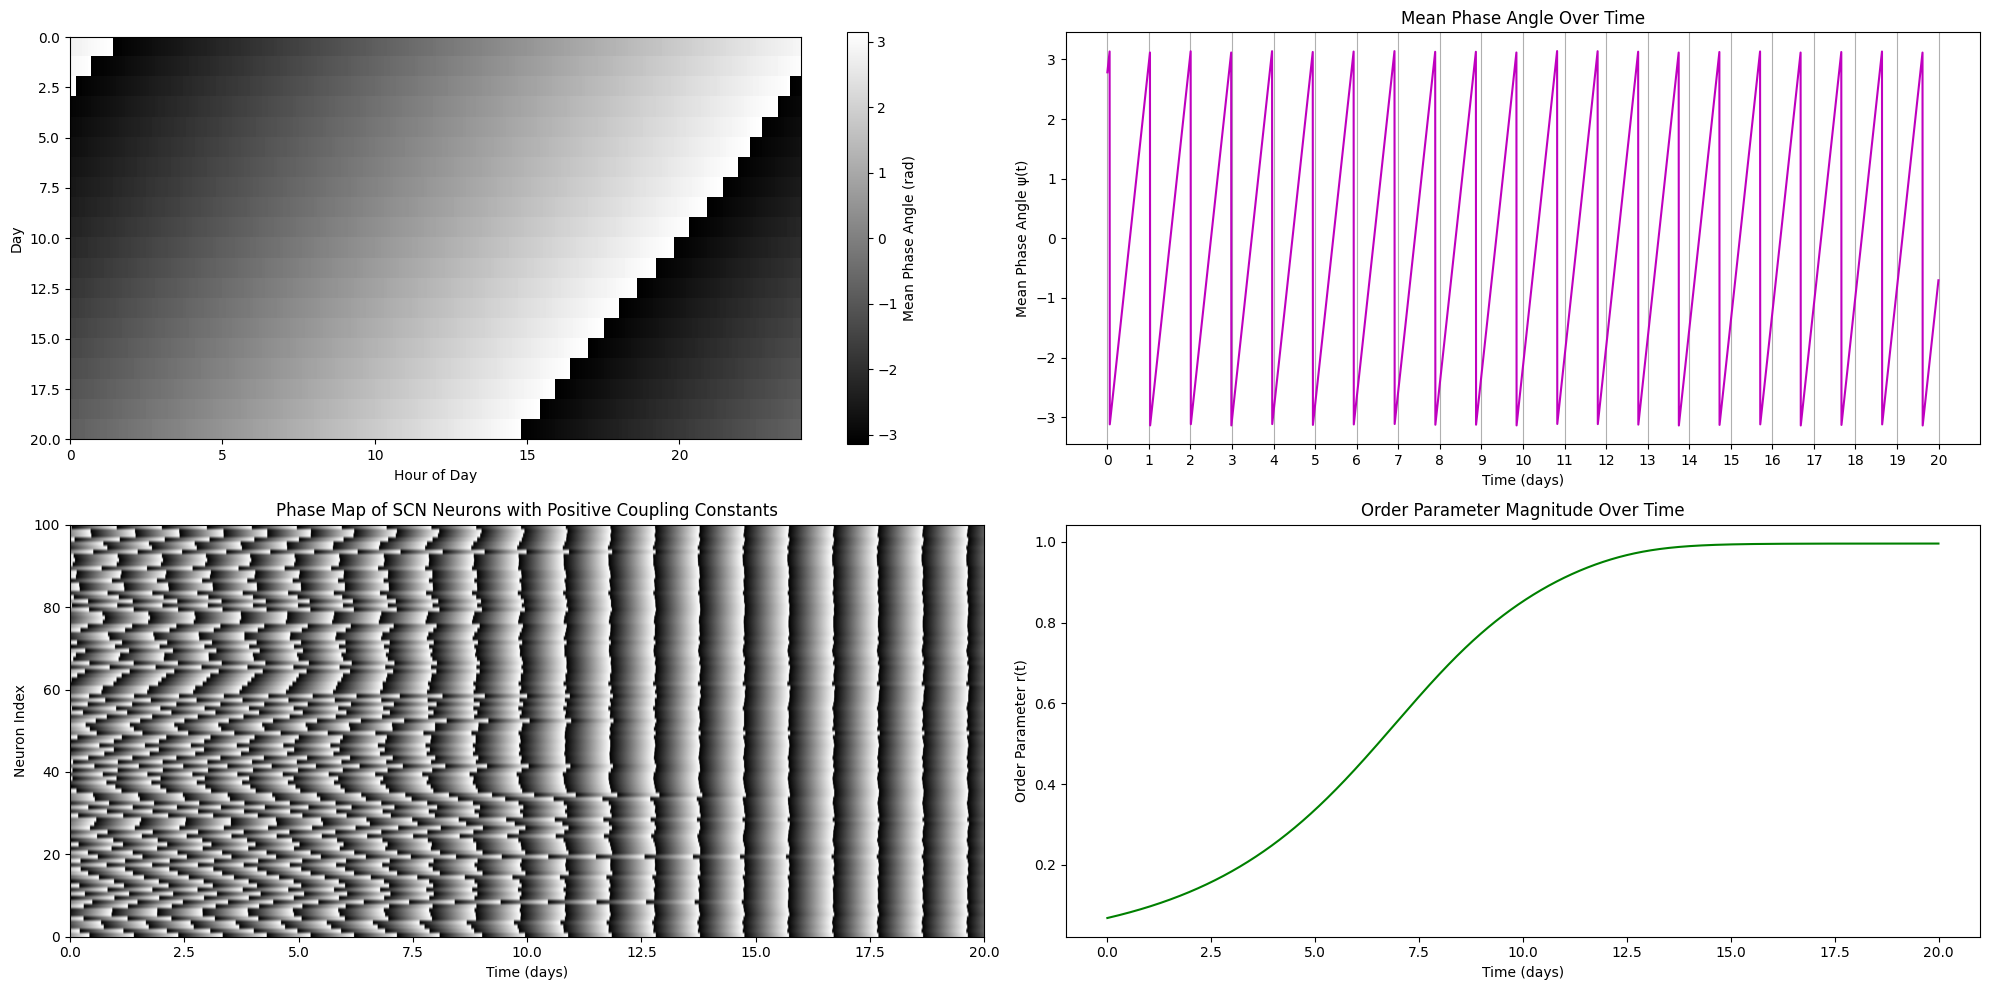

In [4]:
#Baseline
N = 100  # Number of oscillators

T = 24 * 20  # duration (hrs * day)
dt = 0.1   #(hrs)
time = np.arange(0, T, dt)

mean_period = 23.5  #hrs
std_period = 0.2 

# Initialize natural frequencies with variability

#g(ω)～N(loc,scale**2)
ω = np.random.normal(loc=2 * np.pi / mean_period, scale=(2 * np.pi / mean_period**2)*std_period, size=N) #g(ω)~N(loc,scale**2)

# Initialize phases randomly (initial condition)
phases = np.random.uniform(-np.pi, np.pi, N) # scale=0.5#######################

K_matrix = np.random.uniform(0, 0.05, (N, N))
K_matrix = (K_matrix + K_matrix.T) / 2
np.fill_diagonal(K_matrix, 0)

# Storage for phase evolution
phase_history = np.zeros((N, len(time))) # shape = (index, timepoint)

#r(t) & psi(t)
r_values = np.zeros(len(time))  # r(t): order parameter
psi_values = np.zeros(len(time)) # psi(t): mean phase

for t in tqdm(range(len(time)), desc="Simulating", ncols=80):

    phase_history[:, t] = phases  # Store current phases
    
    # Compute the order parameter r and mean phase psi
    order_param = np.mean(np.exp(1j * phases)) ; '->np.mean(complex number) = np.ang + np.abs'
    r_values[t] = np.abs(order_param)
    psi_values[t] = np.angle(order_param)

    for i in range(N):
        coupling_sum = 0
        
        for j in range(N):
            coupling_sum += K_matrix[i,j] * np.sin(phases[j] - phases[i])
        
        phases[i] += (ω[i] + (1/N) * coupling_sum ) * dt

    phases = np.mod(phases+np.pi, 2 * np.pi)-np.pi  # Keep phases within [0, 2π]

fig, axs = subplots(2, 2, figsize=(20, 10))

num_days = int(T / 24)
steps_per_day = int(24 / dt)
total_steps = num_days * steps_per_day
psi_2d = psi_values[:total_steps].reshape(num_days, steps_per_day)

im = axs[0,0].imshow(
    psi_2d,
    aspect=0.66,
    origin='lower',
    extent=[0, 24, 0, num_days],
    cmap='grey',  # or any other colormap
    interpolation= 'none'  # or 'none'
)
axs[0,0].invert_yaxis()
axs[0,0].set_xlabel('Hour of Day')
axs[0,0].set_ylabel('Day')

# Optional colorbar
cbar = fig.colorbar(im, ax=axs[0,0], label='Mean Phase Angle (rad)')

axs[0,1].plot(time / 24, psi_values, color='m')
axs[0,1].set_xlabel('Time (days)')
axs[0,1].set_ylabel('Mean Phase Angle ψ(t)')
axs[0,1].set_title('Mean Phase Angle Over Time')
axs[0,1].xaxis.set_major_locator(ticker.MultipleLocator(1))
axs[0,1].grid(True, axis='x', which='major')


phase_norm = (phase_history / (2 * np.pi)) * 255  # Normalize phase to grayscale (0-255)
axs[1,0].imshow(phase_norm, aspect='auto', cmap='gray', origin='lower',
              extent=[0, T / 24, 0, N])
axs[1,0].set_xlabel('Time (days)')
axs[1,0].set_ylabel('Neuron Index')
axs[1,0].set_title('Phase Map of SCN Neurons with Positive Coupling Constants')

# Third plot: Order parameter magnitude r(t) over time
axs[1,1].plot(time / 24, r_values, color='g')
axs[1,1].set_xlabel('Time (days)')
axs[1,1].set_ylabel('Order Parameter r(t)')
axs[1,1].set_title('Order Parameter Magnitude Over Time')

tight_layout()
show()

std = 0.2

phase initialization $[-\frac{\pi}{2}, \frac{\pi}{2}] \rightarrow~\text{smaller variation}$

Simulating: 100%|███████████████████████████| 4800/4800 [00:59<00:00, 80.74it/s]


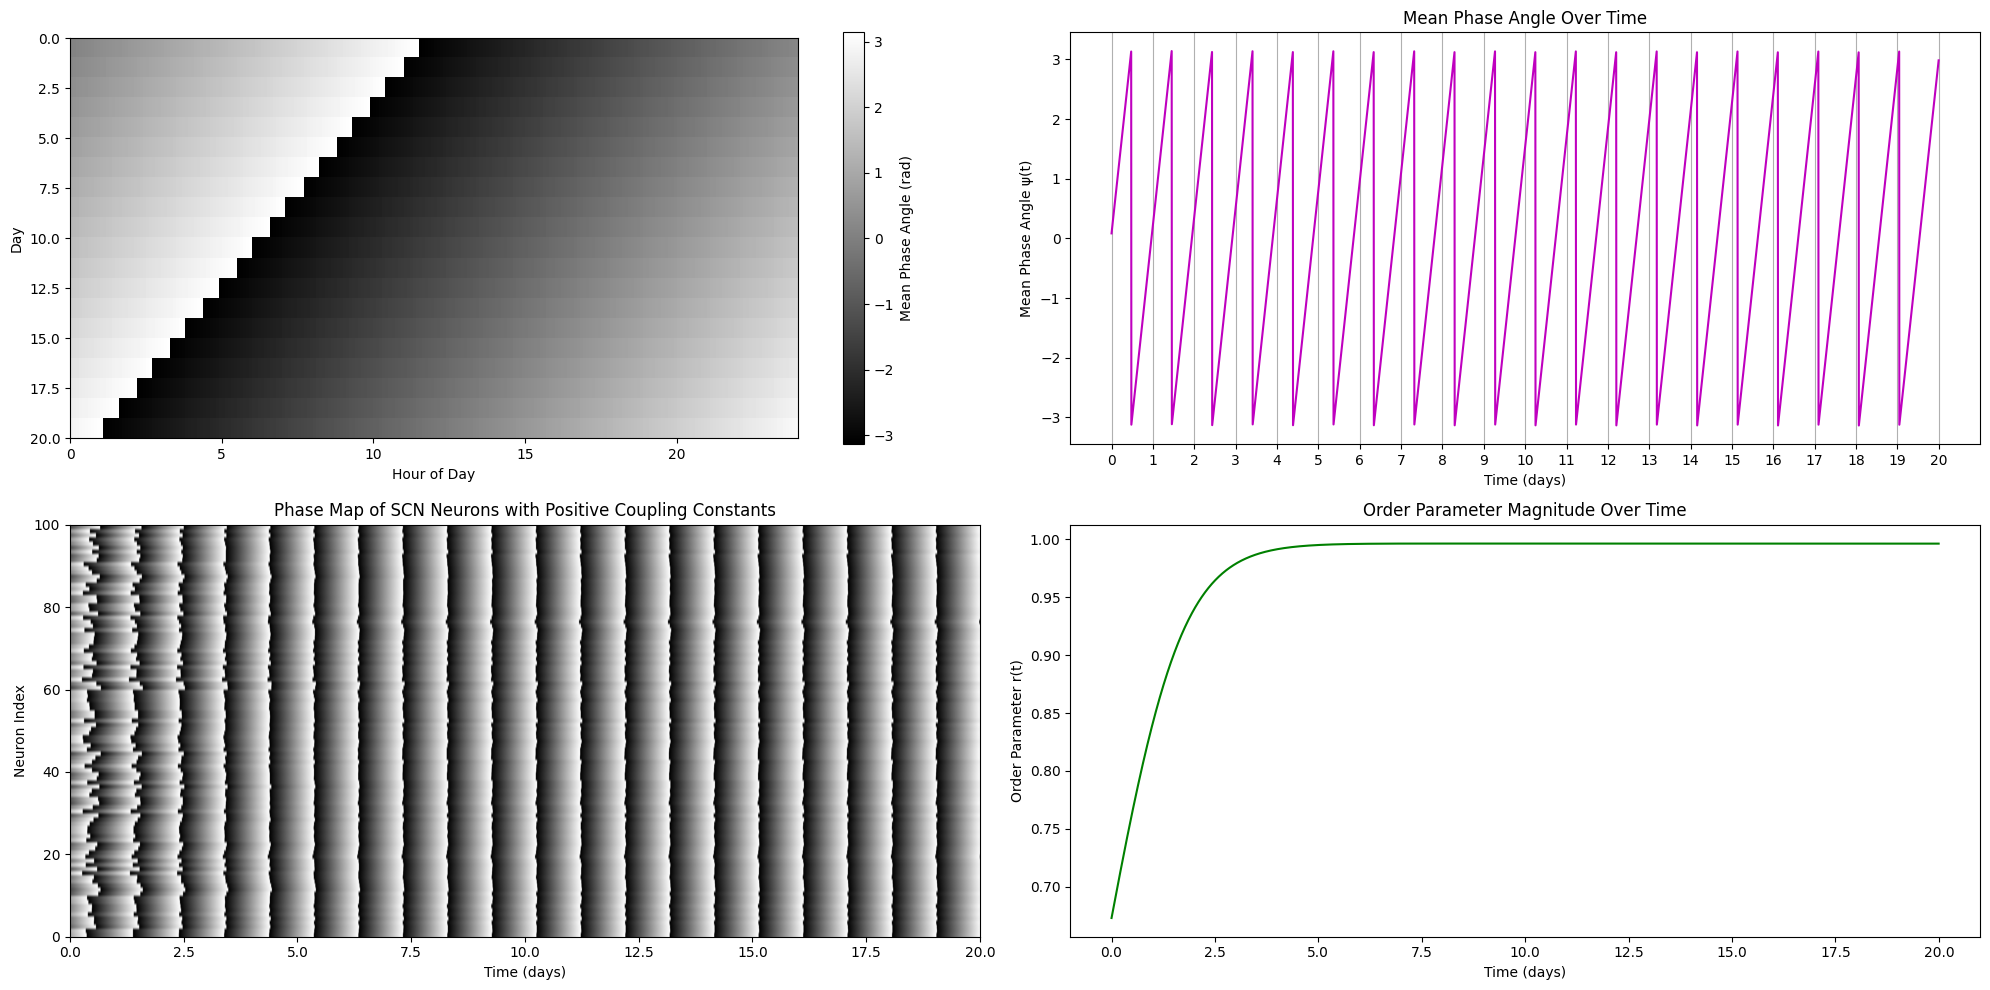

In [5]:
#Baseline
N = 100  # Number of oscillators

T = 24 * 20  # duration (hrs * day)
dt = 0.1   #(hrs)
time = np.arange(0, T, dt)

mean_period = 23.5  #hrs
std_period = 0.2 

# Initialize natural frequencies with variability

ω = np.random.normal(loc=2 * np.pi / mean_period, scale=(2 * np.pi / mean_period**2)*std_period, size=N) #g(ω)~N(loc,scale**2)

# Initialize phases randomly (initial condition)
phases = np.random.uniform(-0.5*np.pi, 0.5*np.pi, N) # scale=0.5#######################
init_phases=phases
K_matrix = np.random.uniform(0, 0.05, (N, N))
K_matrix = (K_matrix + K_matrix.T) / 2
np.fill_diagonal(K_matrix, 0)

# Storage for phase evolution
phase_history = np.zeros((N, len(time))) # shape = (index, timepoint)

#r(t) & psi(t)
r_values = np.zeros(len(time))  # r(t): order parameter
psi_values = np.zeros(len(time)) # psi(t): mean phase

for t in tqdm(range(len(time)), desc="Simulating", ncols=80):

    phase_history[:, t] = phases  # Store current phases
    
    # Compute the order parameter r and mean phase psi
    order_param = np.mean(np.exp(1j * phases)) ; '->np.mean(complex number) = np.ang + np.abs'
    r_values[t] = np.abs(order_param)
    psi_values[t] = np.angle(order_param)

    for i in range(N):
        coupling_sum = 0
        
        for j in range(N):
            coupling_sum += K_matrix[i,j] * np.sin(phases[j] - phases[i])
        
        phases[i] += (ω[i] + (1/N) * coupling_sum ) * dt

    phases = np.mod(phases+np.pi, 2 * np.pi)-np.pi  # Keep phases within [0, 2π]

fig, axs = subplots(2, 2, figsize=(20, 10))

num_days = int(T / 24)
steps_per_day = int(24 / dt)
total_steps = num_days * steps_per_day
psi_2d = psi_values[:total_steps].reshape(num_days, steps_per_day)

im = axs[0,0].imshow(
    psi_2d,
    aspect=0.66,
    origin='lower',
    extent=[0, 24, 0, num_days],
    cmap='grey',  # or any other colormap
    interpolation= 'none'  # or 'none'
)
axs[0,0].invert_yaxis()
axs[0,0].set_xlabel('Hour of Day')
axs[0,0].set_ylabel('Day')

# Optional colorbar
cbar = fig.colorbar(im, ax=axs[0,0], label='Mean Phase Angle (rad)')

axs[0,1].plot(time / 24, psi_values, color='m')
axs[0,1].set_xlabel('Time (days)')
axs[0,1].set_ylabel('Mean Phase Angle ψ(t)')
axs[0,1].set_title('Mean Phase Angle Over Time')
axs[0,1].xaxis.set_major_locator(ticker.MultipleLocator(1))
axs[0,1].grid(True, axis='x', which='major')


phase_norm = (phase_history / (2 * np.pi)) * 255  # Normalize phase to grayscale (0-255)
axs[1,0].imshow(phase_norm, aspect='auto', cmap='gray', origin='lower',
              extent=[0, T / 24, 0, N])
axs[1,0].set_xlabel('Time (days)')
axs[1,0].set_ylabel('Neuron Index')
axs[1,0].set_title('Phase Map of SCN Neurons with Positive Coupling Constants')

# Third plot: Order parameter magnitude r(t) over time
axs[1,1].plot(time / 24, r_values, color='g')
axs[1,1].set_xlabel('Time (days)')
axs[1,1].set_ylabel('Order Parameter r(t)')
axs[1,1].set_title('Order Parameter Magnitude Over Time')



tight_layout()
show()

np.savez('free_running_data.npz', omega=ω, init_phases=init_phases, K_matrix=K_matrix, psi_fr=psi_values, r_fr=r_values, his_phase_fr=phase_history)

### high std among neuron period

std=0.5

Simulating: 100%|███████████████████████████| 4800/4800 [01:00<00:00, 78.91it/s]


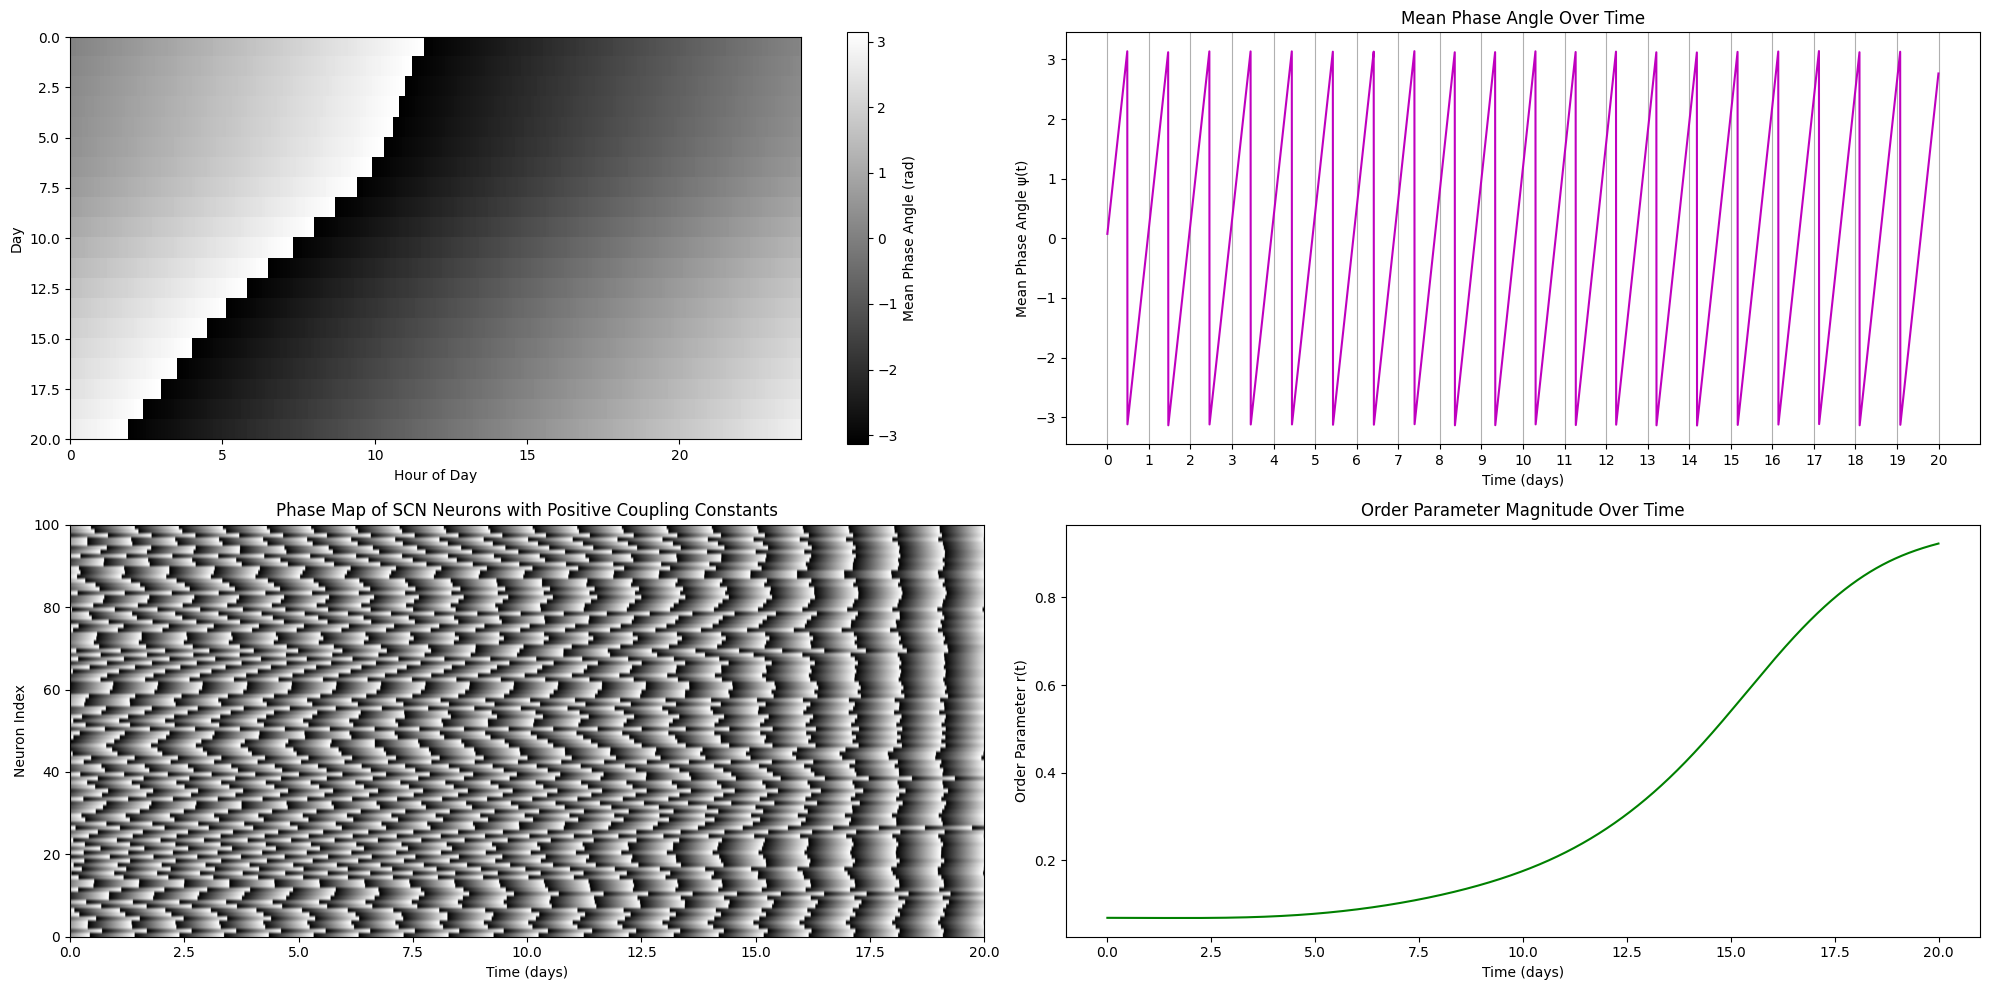

In [6]:
N = 100  # Number of oscillators

T = 24 * 20  # duration (hrs * day)
dt = 0.1   #(hrs)
time = np.arange(0, T, dt)

mean_period = 23.5  #hrs
std_period = 0.5

# Initialize natural frequencies with variability

ω = np.random.normal(loc=2 * np.pi / mean_period, scale=(2 * np.pi / mean_period**2)*std_period, size=N) #g(ω)

# Initialize phases randomly (initial condition)
phases = np.random.uniform(-np.pi, np.pi, N) # scale=0.5#######################


K_matrix = np.random.uniform(0, 0.05, (N, N))
K_matrix = (K_matrix + K_matrix.T) / 2
np.fill_diagonal(K_matrix, 0)

# Storage for phase evolution
phase_history = np.zeros((N, len(time))) # shape = (index, timepoint)

#r(t) & psi(t)
r_values = np.zeros(len(time))  # r(t): order parameter
psi_values = np.zeros(len(time)) # psi(t): mean phase

for t in tqdm(range(len(time)), desc="Simulating", ncols=80):

    phase_history[:, t] = phases  # Store current phases
    
    # Compute the order parameter r and mean phase psi
    order_param = np.mean(np.exp(1j * phases)) ; '->np.mean(complex number) = np.ang + np.abs'
    r_values[t] = np.abs(order_param)
    psi_values[t] = np.angle(order_param)

    for i in range(N):
        coupling_sum = 0
        
        for j in range(N):
            coupling_sum += K_matrix[i,j] * np.sin(phases[j] - phases[i])
        
        phases[i] += (ω[i] + (1/N) * coupling_sum ) * dt

    phases = np.mod(phases+np.pi, 2 * np.pi) - np.pi # Keep phases within [0, 2π]

# mean phase at each timepoint
mean_phase = np.mean(phase_history, axis=0)


fig, axs = subplots(2, 2, figsize=(20, 10))

num_days = int(T / 24)
steps_per_day = int(24 / dt)
total_steps = num_days * steps_per_day
psi_2d = psi_values[:total_steps].reshape(num_days, steps_per_day)

im = axs[0,0].imshow(
    psi_2d,
    aspect=0.66,
    origin='lower',
    extent=[0, 24, 0, int(num_days)],
    cmap='grey',  # or any other colormap
    interpolation= 'none'  # or 'none'
)
axs[0,0].invert_yaxis()
# Label axes
axs[0,0].set_xlabel('Hour of Day')
axs[0,0].set_ylabel('Day')

# Optional colorbar
cbar = fig.colorbar(im, ax=axs[0,0], label='Mean Phase Angle (rad)')

axs[0,1].plot(time / 24, psi_values, color='m')
axs[0,1].set_xlabel('Time (days)')
axs[0,1].set_ylabel('Mean Phase Angle ψ(t)')
axs[0,1].set_title('Mean Phase Angle Over Time')
axs[0,1].xaxis.set_major_locator(ticker.MultipleLocator(1))
axs[0,1].grid(True, axis='x', which='major')


phase_norm = (phase_history / (2 * np.pi)) * 255  # Normalize phase to grayscale (0-255)
axs[1,0].imshow(phase_norm, aspect='auto', cmap='gray', origin='lower',
              extent=[0, T / 24, 0, N])
axs[1,0].set_xlabel('Time (days)')
axs[1,0].set_ylabel('Neuron Index')
axs[1,0].set_title('Phase Map of SCN Neurons with Positive Coupling Constants')

# Third plot: Order parameter magnitude r(t) over time
axs[1,1].plot(time / 24, r_values, color='g')
axs[1,1].set_xlabel('Time (days)')
axs[1,1].set_ylabel('Order Parameter r(t)')
axs[1,1].set_title('Order Parameter Magnitude Over Time')



tight_layout()
show()

### period std = 1 (w/ double simulation time)

Simulating: 100%|███████████████████████████| 9600/9600 [02:00<00:00, 79.79it/s]


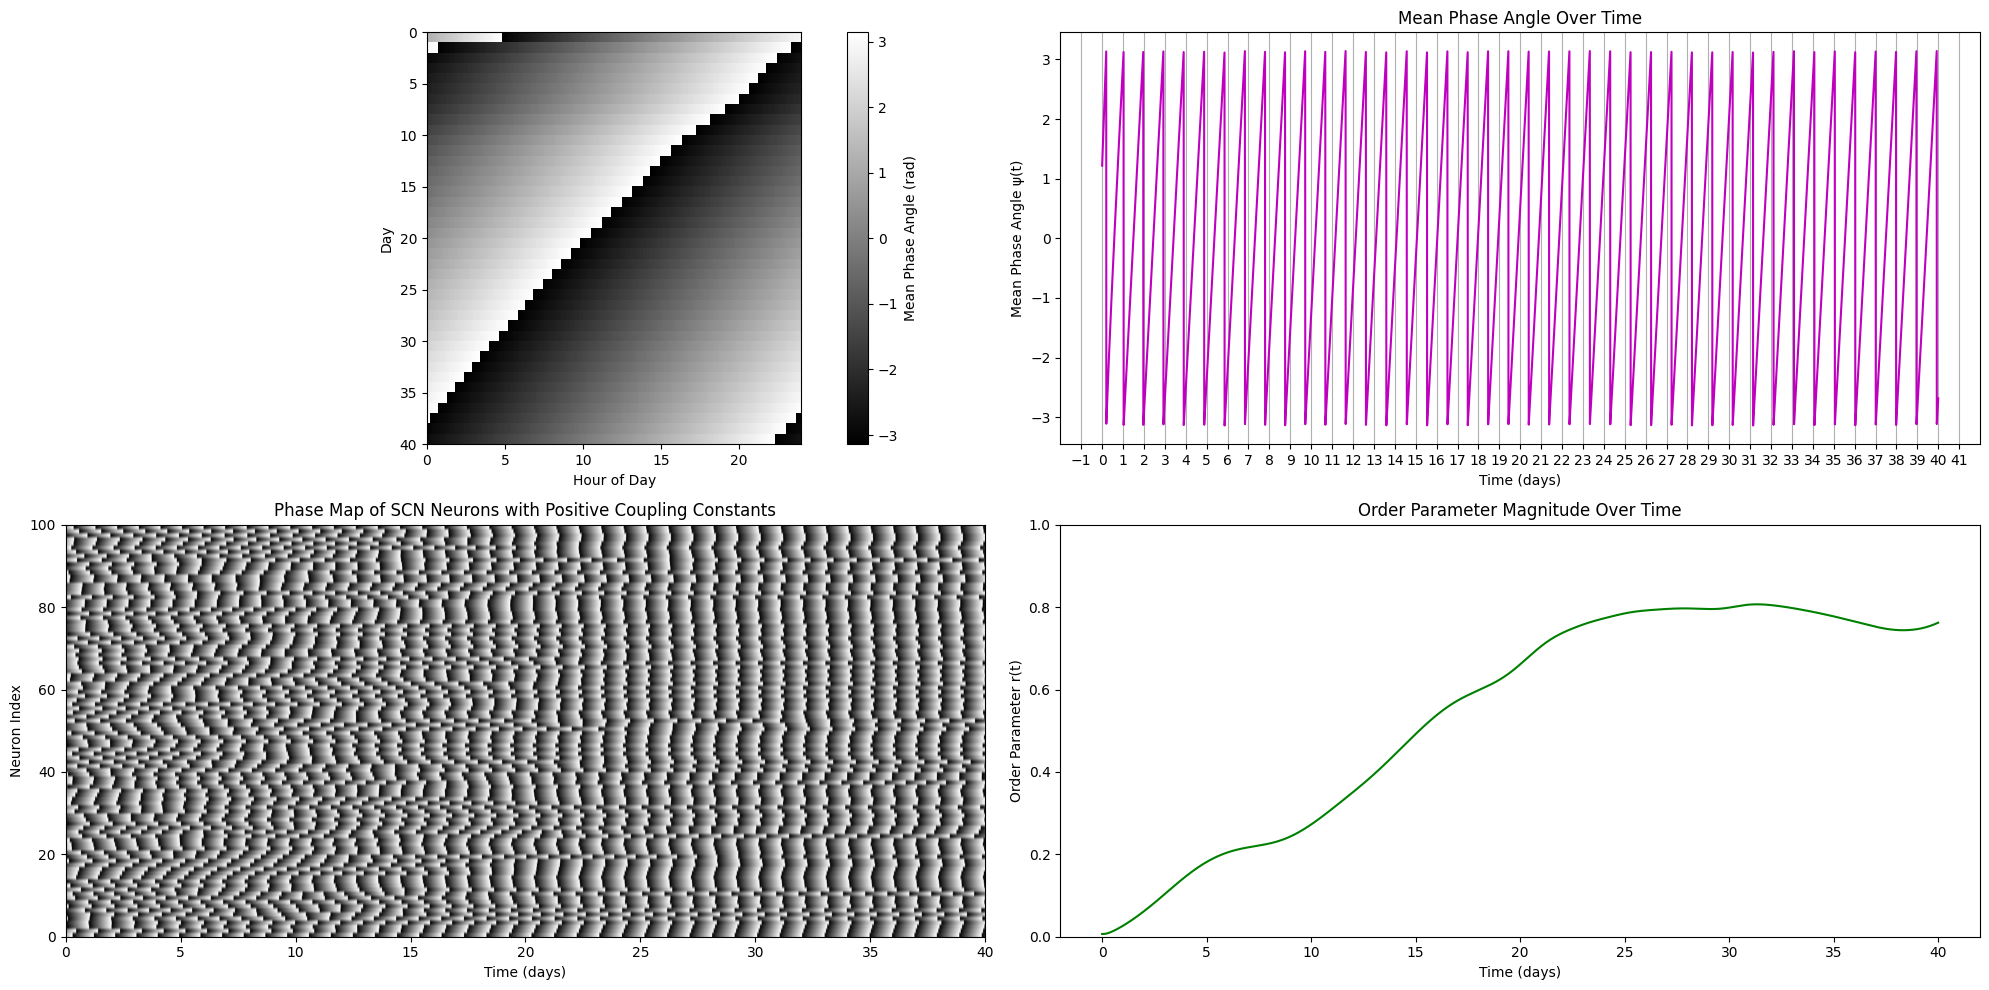

In [9]:
N = 100  # Number of oscillators

T = 24 * 40  # duration (hrs * day)
dt = 0.1   #(hrs)
time = np.arange(0, T, dt)

mean_period = 23.5  #hrs
std_period = 1

# Initialize natural frequencies with variability

ω = np.random.normal(loc=2 * np.pi / mean_period, scale=(2 * np.pi / mean_period**2)*std_period, size=N) #g(ω)

# Initialize phases randomly (initial condition)
phases = np.random.uniform(-np.pi, np.pi, N) # scale=0.5#######################


K_matrix = np.random.uniform(0, 0.05, (N, N))
K_matrix = (K_matrix + K_matrix.T) / 2
np.fill_diagonal(K_matrix, 0)

# Storage for phase evolution
phase_history = np.zeros((N, len(time))) # shape = (index, timepoint)

#r(t) & psi(t)
r_values = np.zeros(len(time))  # r(t): order parameter
psi_values = np.zeros(len(time)) # psi(t): mean phase

for t in tqdm(range(len(time)), desc="Simulating", ncols=80):

    phase_history[:, t] = phases  # Store current phases
    
    # Compute the order parameter r and mean phase psi
    order_param = np.mean(np.exp(1j * phases)) ; '->np.mean(complex number) = np.ang + np.abs'
    r_values[t] = np.abs(order_param)
    psi_values[t] = np.angle(order_param)

    for i in range(N):
        coupling_sum = 0
        
        for j in range(N):
            coupling_sum += K_matrix[i,j] * np.sin(phases[j] - phases[i])
        
        phases[i] += (ω[i] + (1/N) * coupling_sum ) * dt

    phases = np.mod(phases+np.pi, 2 * np.pi)-np.pi  # Keep phases within [0, 2π]

# mean phase at each timepoint
mean_phase = np.mean(phase_history, axis=0)


fig, axs = subplots(2, 2, figsize=(20, 10))

num_days = int(T / 24)
steps_per_day = int(24 / dt)
total_steps = num_days * steps_per_day
psi_2d = psi_values[:total_steps].reshape(num_days, steps_per_day)

im = axs[0,0].imshow(
    psi_2d,
    aspect=0.66,
    origin='lower',
    extent=[0, 24, 0, num_days],
    cmap='grey',  # or any other colormap
    interpolation= 'none'  # or 'none'
)
axs[0,0].invert_yaxis()
# Label axes
axs[0,0].set_xlabel('Hour of Day')
axs[0,0].set_ylabel('Day')

# Optional colorbar
cbar = fig.colorbar(im, ax=axs[0,0], label='Mean Phase Angle (rad)')

axs[0,1].plot(time / 24, psi_values, color='m')
axs[0,1].set_xlabel('Time (days)')
axs[0,1].set_ylabel('Mean Phase Angle ψ(t)')
axs[0,1].set_title('Mean Phase Angle Over Time')
axs[0,1].xaxis.set_major_locator(ticker.MultipleLocator(1))
axs[0,1].grid(True, axis='x', which='major')


phase_norm = (phase_history / (2 * np.pi)) * 255  # Normalize phase to grayscale (0-255)
axs[1,0].imshow(phase_norm, aspect='auto', cmap='gray', origin='lower',
              extent=[0, T / 24, 0, N])
axs[1,0].set_xlabel('Time (days)')
axs[1,0].set_ylabel('Neuron Index')
axs[1,0].set_title('Phase Map of SCN Neurons with Positive Coupling Constants')

# Third plot: Order parameter magnitude r(t) over time
axs[1,1].plot(time / 24, r_values, color='g')
axs[1,1].set_xlabel('Time (days)')
axs[1,1].set_ylabel('Order Parameter r(t)')
axs[1,1].set_ylim(0,1)
axs[1,1].set_title('Order Parameter Magnitude Over Time')



tight_layout()
show()

## light input

$\large Assumptions:\\[5pt]$
$~~~~1.~ω$ ~ $g(ω)=N(\mu, \sigma)\\[5pt]$
$~~~~2.~heterogenous + dense~Fully$-$Connected~oscillators\\[5pt]$
$~~~~3.~square~function~daylight~input$

### square daylight 

In [10]:
N = 100  # Number of oscillators

T = 24 * 20  # duration (hrs * day)
dt = 0.1   #(hrs)
time = np.arange(0, T, dt)

light_max=0.01

mean_period = 23.5  #hrs
std_period = 0.2 

#initialization
omega, init_phases, K_matrix = fetch()

ω=omega
phases_l = init_phases

# Storage for phase evolution
his_phase_l = np.zeros((N, len(time))) # shape = (index, timepoint)

#r(t) & psi(t)
r_l = np.zeros(len(time))  # r(t): order parameter
psi_l = np.zeros(len(time)) # psi(t): mean phase angle

for t in tqdm(range(len(time)), desc="Simulating", ncols=80):
    time_of_day = (t*dt) % 24
    pl = 1 if time_of_day < 12 else 0
    light_input = light_max * pl 
    
    his_phase_l[:, t] = phases_l
    
    # Compute the order parameter r and mean phase psi
    order_param = np.mean(np.exp(1j * phases_l)) ; '->np.mean(complex number) = np.ang + np.abs'
    r_l[t] = np.abs(order_param)
    psi_l[t] = np.angle(order_param)

    for i in range(N):
        coupling_sum = 0
        
        for j in range(N):
            coupling_sum += K_matrix[i,j] * np.sin(phases_l[j] - phases_l[i])
        
        phases_l[i] += (ω[i] + (1/N) * coupling_sum + light_input) * dt

    phases_l = np.mod(phases_l+np.pi,  2 * np.pi) - np.pi

Simulating: 100%|███████████████████████████| 4800/4800 [00:59<00:00, 81.14it/s]


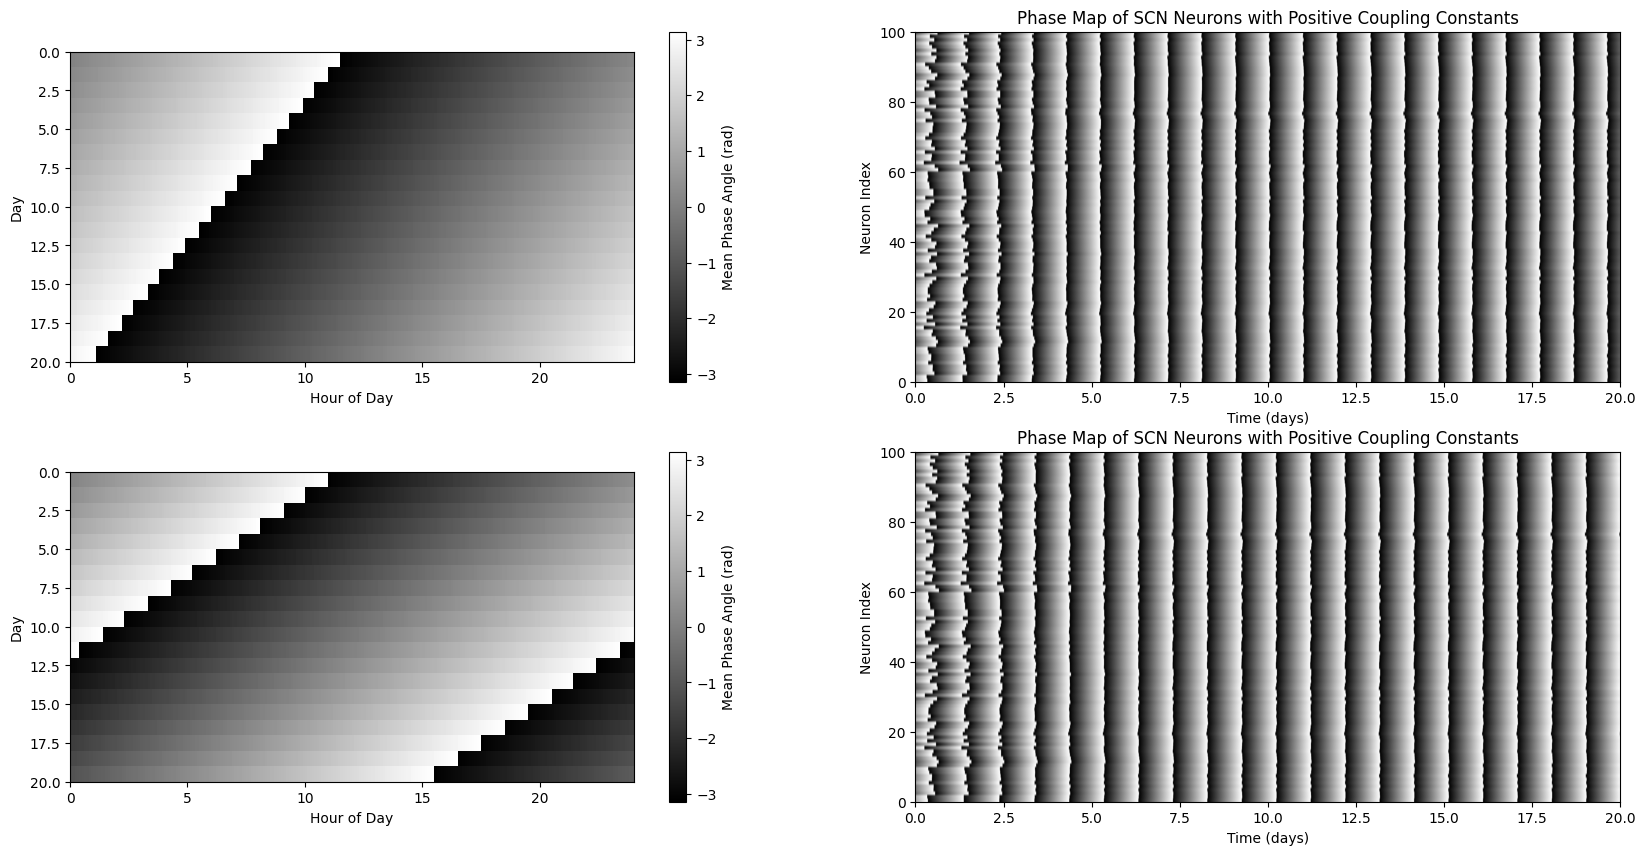

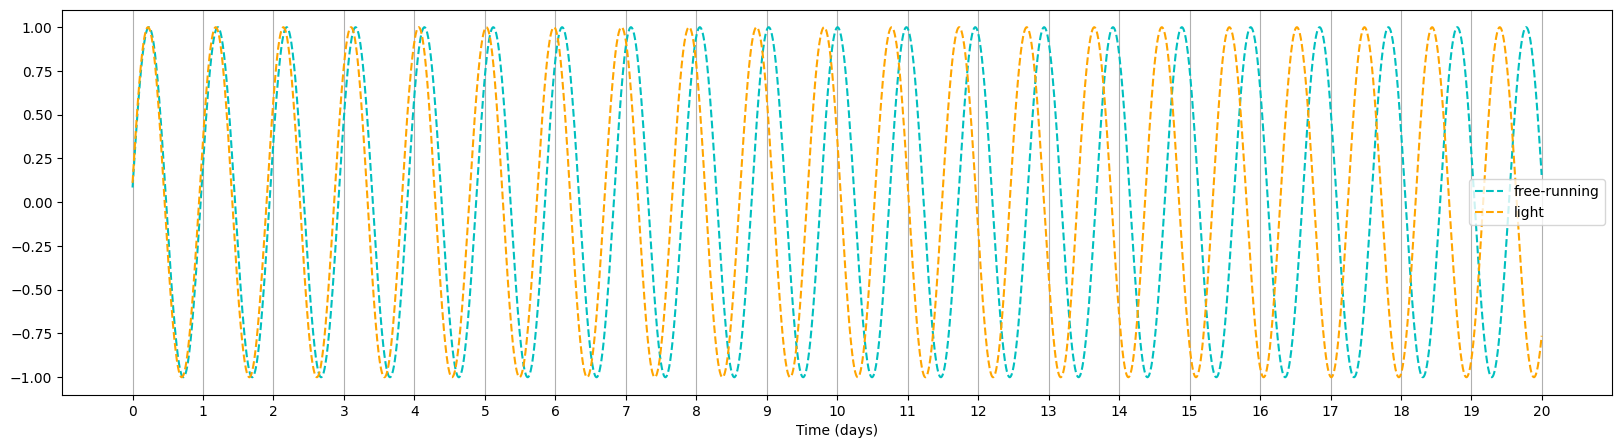

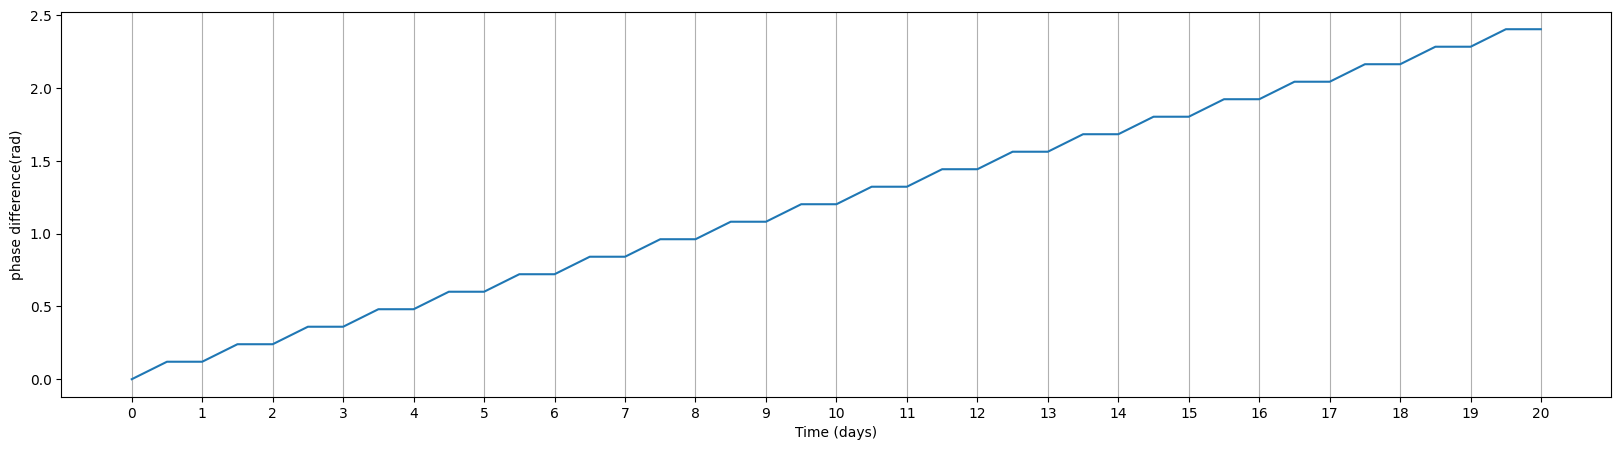

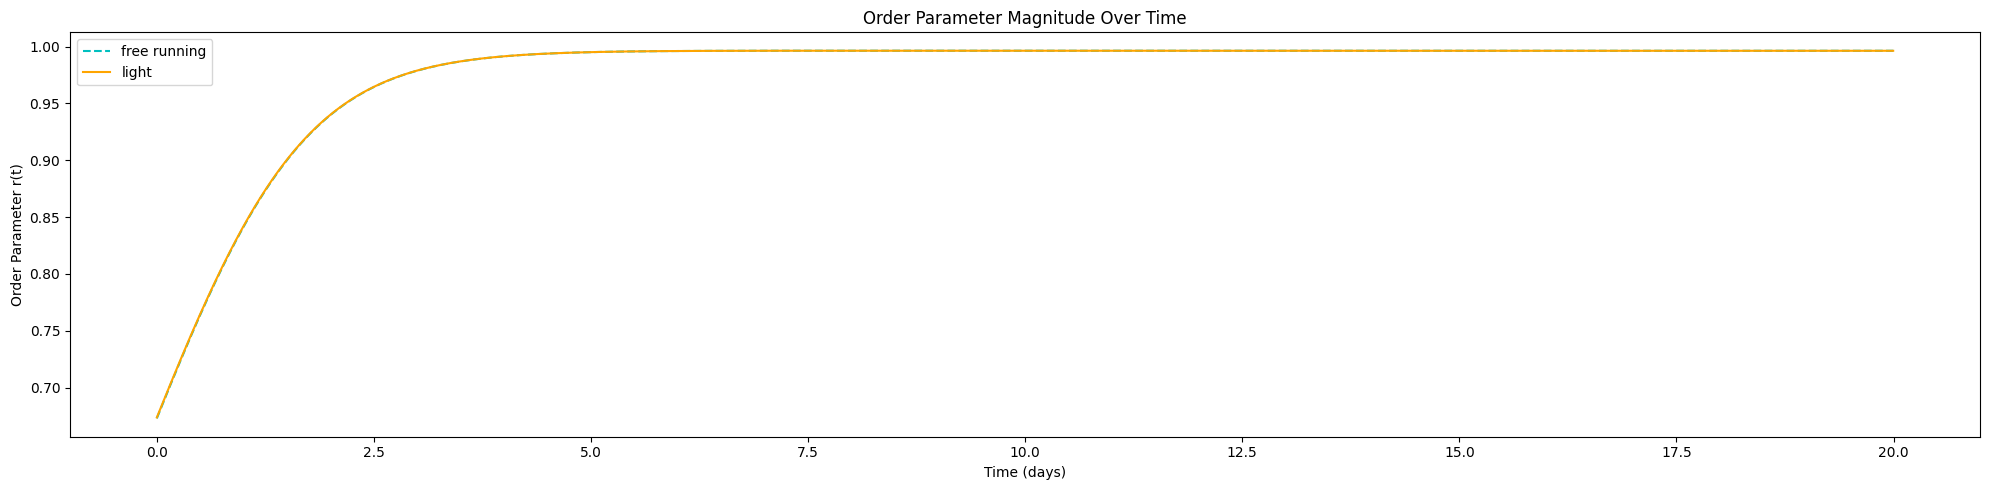

In [11]:
compare(his_phase_l, psi_l, r_l)

$\Large \rightarrow phase~advance$

### sinusoidal daylight

In [12]:
N = 100  # Number of oscillators

T = 24 * 20  # duration (hrs * day)
dt = 0.1   #(hrs)
time = np.arange(0, T, dt)

light_max=0.05

mean_period = 23.5  #hrs
std_period = 0.2

#initialization
omega, init_phases, K_matrix = fetch()

ω=omega
phases_l = init_phases

# Storage for phase evolution
his_phase_l = np.zeros((N, len(time))) # shape = (index, timepoint)

#r(t) & psi(t)
r_l = np.zeros(len(time))  # r(t): order parameter
psi_l = np.zeros(len(time)) # psi(t): mean phase angle

for t in tqdm(range(len(time)), desc="Simulating", ncols=80):
    time_of_day = (t*dt) % 24
    pl = 1 if time_of_day < 12 else 0
    light_input = light_max * pl * np.sin(2*np.pi*(time_of_day/24))
    
    his_phase_l[:, t] = phases_l
    
    # Compute the order parameter r and mean phase psi
    order_param = np.mean(np.exp(1j * phases_l)) ; '->np.mean(complex number) = np.ang + np.abs'
    r_l[t] = np.abs(order_param)
    psi_l[t] = np.angle(order_param)

    for i in range(N):
        coupling_sum = 0
        
        for j in range(N):
            coupling_sum += K_matrix[i,j] * np.sin(phases_l[j] - phases_l[i])
        
        phases_l[i] += (ω[i] + (1/N) * coupling_sum + light_input) * dt

    phases_l = np.mod(phases_l+np.pi,  2 * np.pi) - np.pi

Simulating: 100%|███████████████████████████| 4800/4800 [01:00<00:00, 79.00it/s]


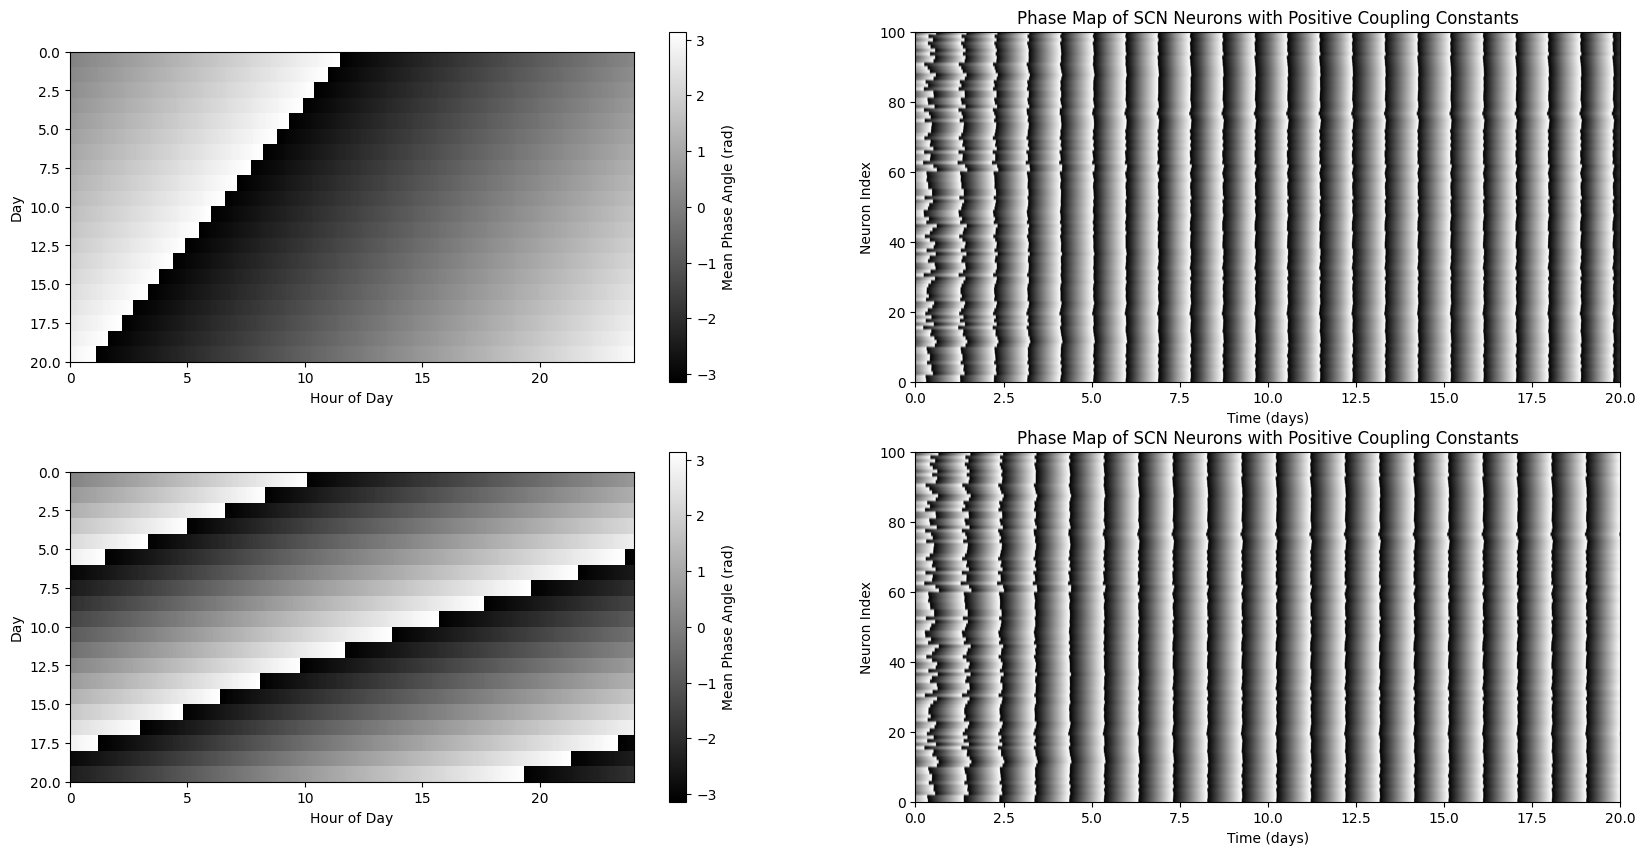

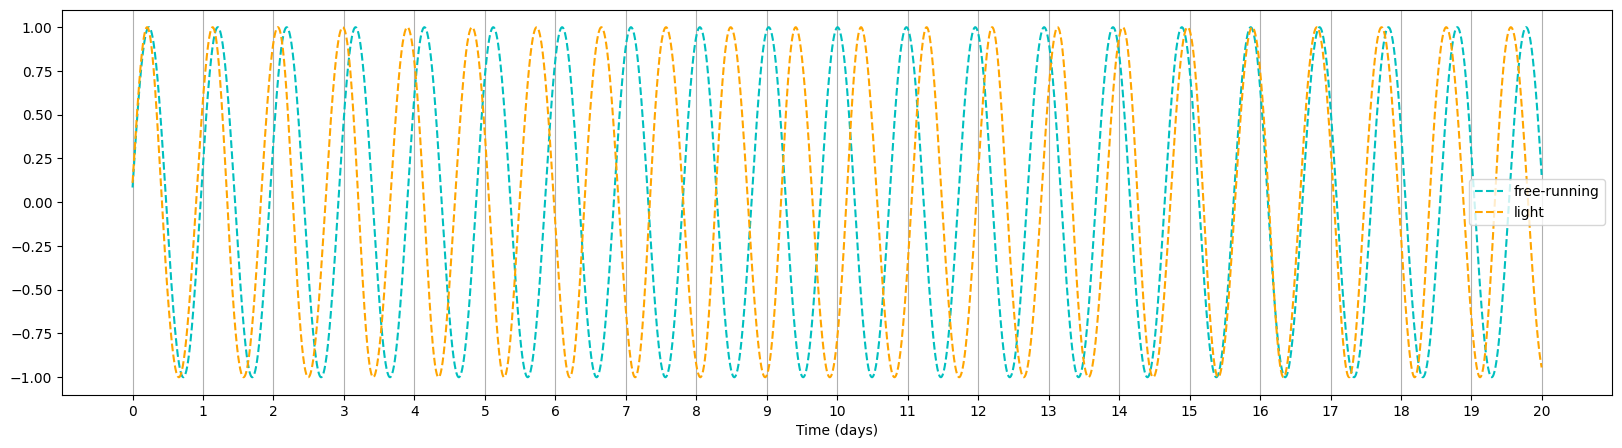

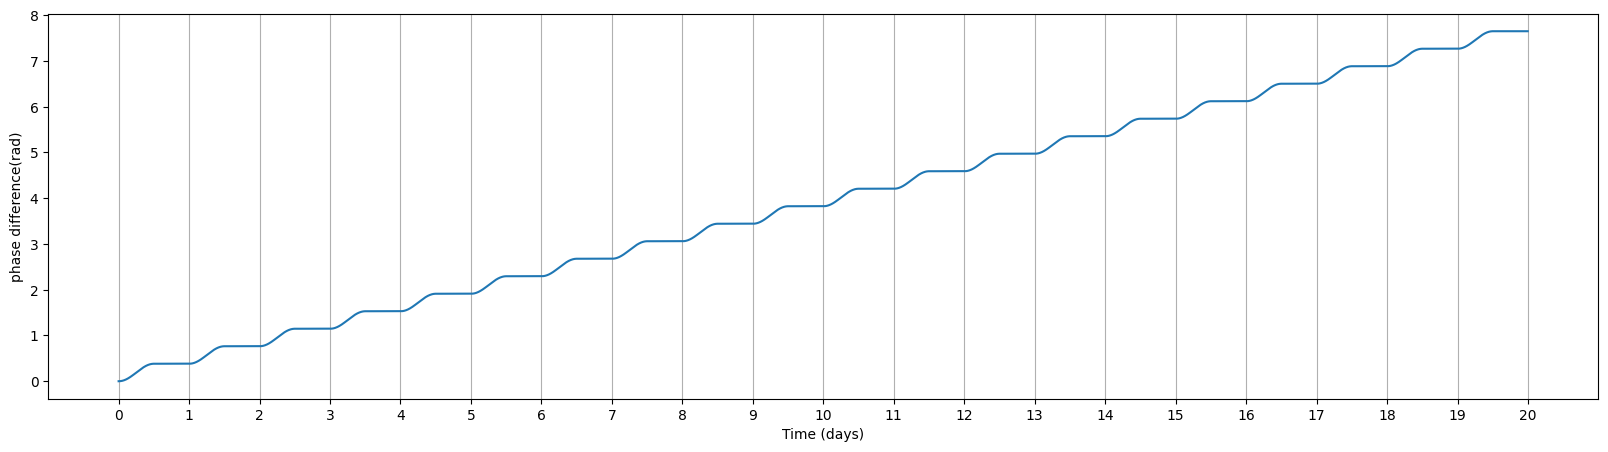

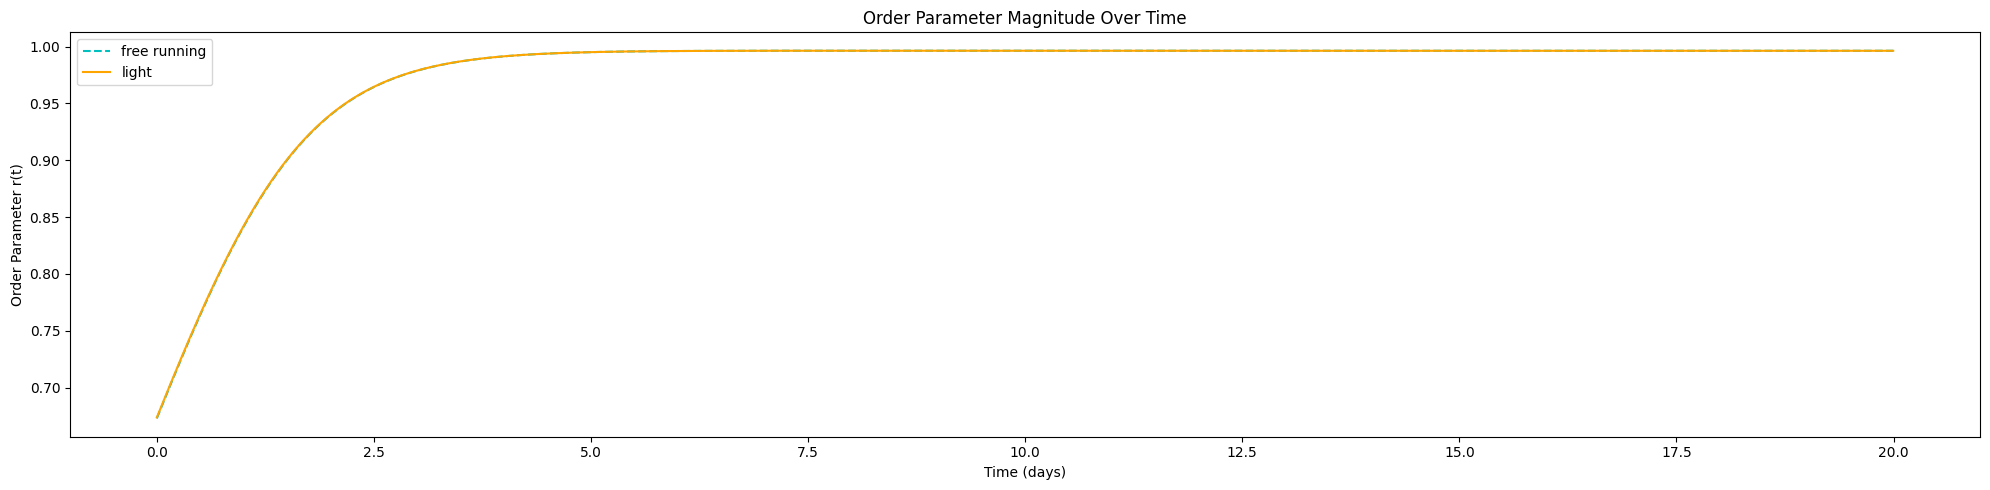

In [13]:
compare(his_phase_l, psi_l, r_l)

lightmax=0.05

interaction: $\large \frac{d\theta_i}{dt}~=~$ $light~input*sin[2\pi(\frac{time}{24})-\theta_i] $

In [ ]:
N = 100  # Number of oscillators

T = 24 * 20  # duration (hrs * day)
dt = 0.1   #(hrs)
time = np.arange(0, T, dt)

light_max=0.05

mean_period = 23.5  #hrs
std_period = 0.2

#initialization
omega, init_phases, K_matrix = fetch()

ω=omega
phases_l = init_phases

# Storage for phase evolution
his_phase_l = np.zeros((N, len(time))) # shape = (index, timepoint)

#r(t) & psi(t)
r_l = np.zeros(len(time))  # r(t): order parameter
psi_l = np.zeros(len(time)) # psi(t): mean phase angle

for t in tqdm(range(len(time)), desc="Simulating", ncols=80):
    time_of_day = (t*dt) % 24
    pl = 1 if time_of_day < 12 else 0
    light_input = light_max * pl
    
    his_phase_l[:, t] = phases_l
    
    # Compute the order parameter r and mean phase psi
    order_param = np.mean(np.exp(1j * phases_l)) ; '->np.mean(complex number) = np.ang + np.abs'
    r_l[t] = np.abs(order_param)
    psi_l[t] = np.angle(order_param)

    for i in range(N):
        coupling_sum = 0
        
        for j in range(N):
            coupling_sum += K_matrix[i,j] * np.sin(phases_l[j] - phases_l[i])
        
        phases_l[i] += (ω[i] + (1/N) * coupling_sum + light_input * np.sin((2*np.pi*(time_of_day/24)-phases_l[i])) ) * dt

    phases_l = np.mod(phases_l+np.pi,  2 * np.pi) - np.pi

Simulating: 100%|███████████████████████████| 4800/4800 [03:52<00:00, 20.66it/s]


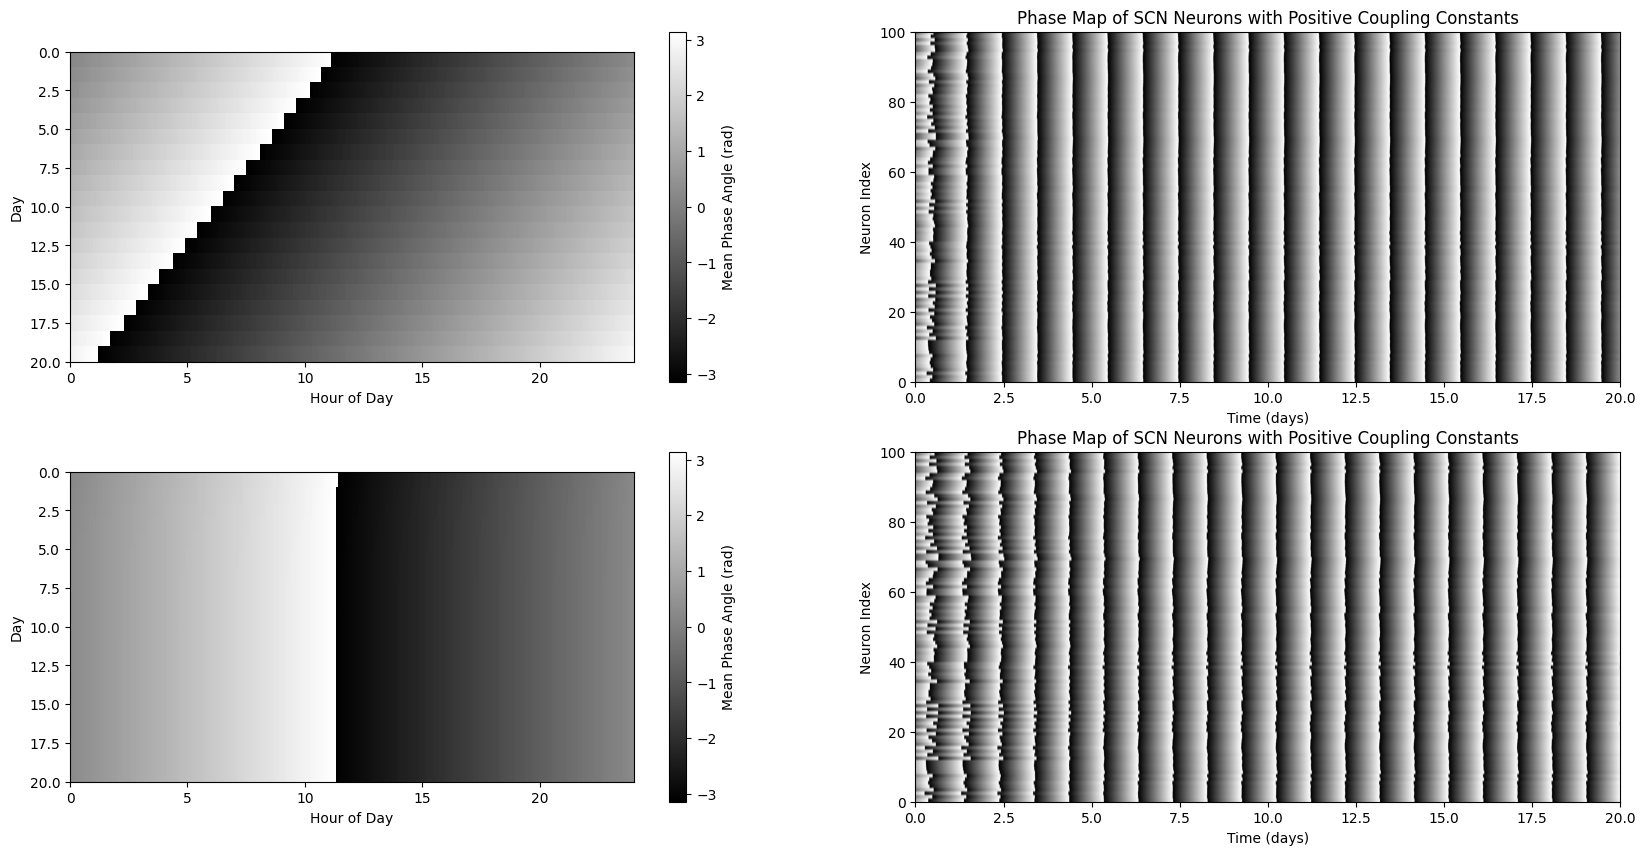

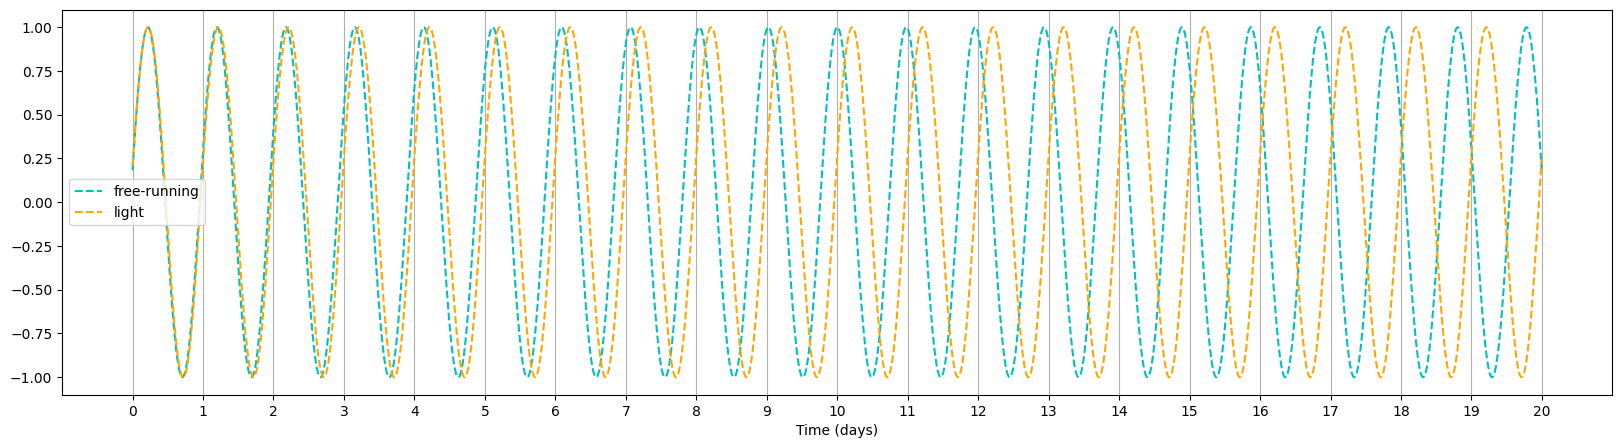

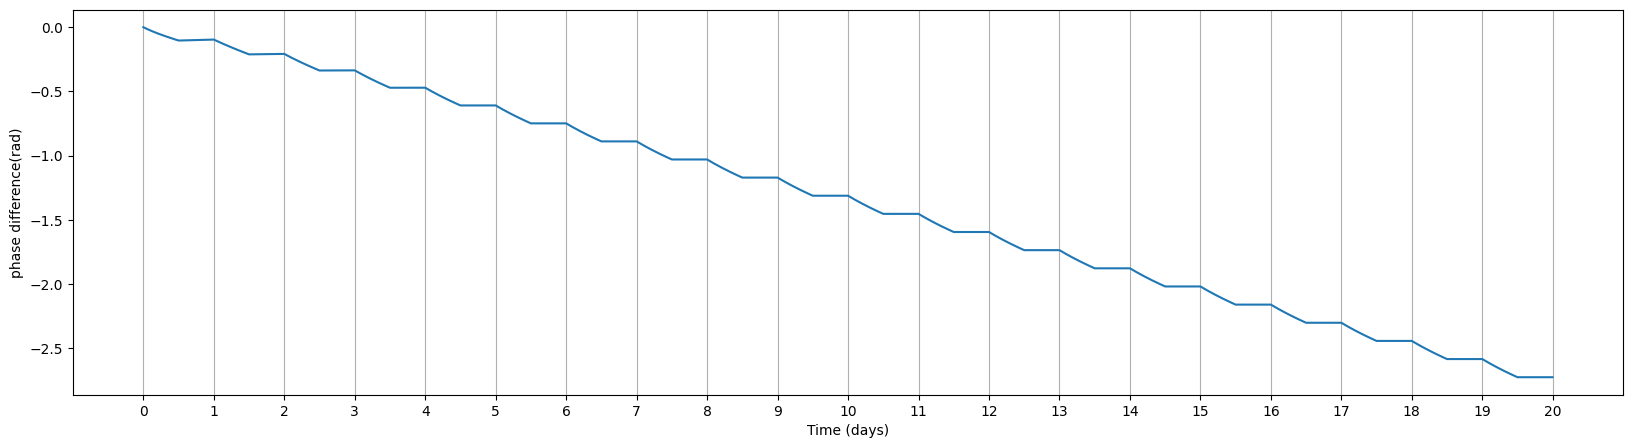

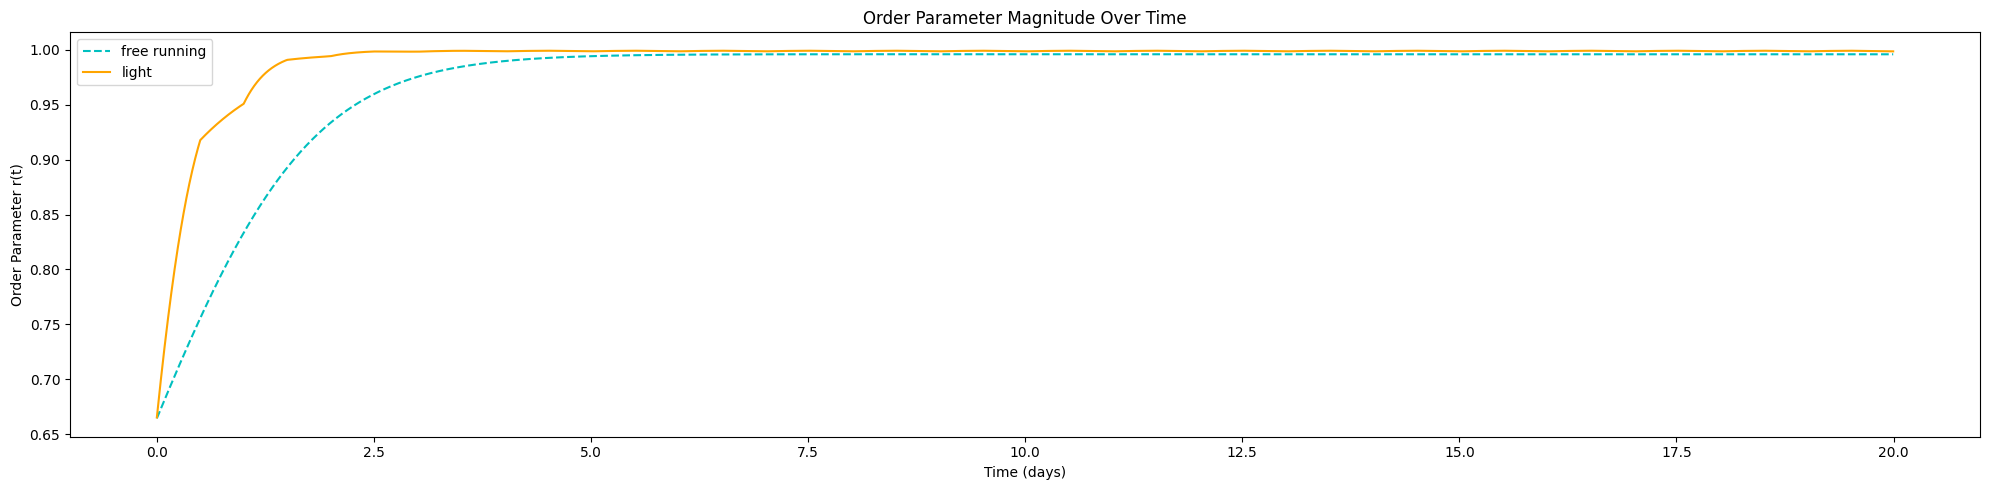

In [63]:
compare(his_phase_l, psi_l, r_l)

$\Large \rightarrow entrainment~to~daylight$
$\\\large so~we~see~phase~delay$

$\Large Realistic(?)~sinusoidal~daylight~with~intrinsic~period~coupling$
1. strength as sin
2. intrinsic coupling

In [4]:
N = 100  # Number of oscillators

T = 24 * 20  # duration (hrs * day)
dt = 0.1   #(hrs)
time = np.arange(0, T, dt)

light_max=0.05

mean_period = 23.5  #hrs
std_period = 0.2

#initialization
omega, init_phases, K_matrix = fetch()

ω=omega
phases_l = init_phases

# Storage for phase evolution
his_phase_l = np.zeros((N, len(time))) # shape = (index, timepoint)

#r(t) & psi(t)
r_l = np.zeros(len(time))  # r(t): order parameter
psi_l = np.zeros(len(time)) # psi(t): mean phase angle

for t in tqdm(range(len(time)), desc="Simulating", ncols=80):
    time_of_day = (t*dt) % 24
    pl = 1 if time_of_day < 12 else 0
    light_input = pl * light_max * np.sin(2*np.pi*(time_of_day/24))
    
    his_phase_l[:, t] = phases_l
    
    # Compute the order parameter r and mean phase psi
    order_param = np.mean(np.exp(1j * phases_l)) ; '->np.mean(complex number) = np.ang + np.abs'
    r_l[t] = np.abs(order_param)
    psi_l[t] = np.angle(order_param)

    for i in range(N):
        coupling_sum = 0
        
        for j in range(N):
            coupling_sum += np.sum(K_matrix[i,j] * np.sin(phases_l[j] - phases_l[i]))
        
        phases_l[i] += (ω[i] + (1/N) * coupling_sum + light_input * np.sin((2*np.pi*(psi_l[t]/mean_period)-phases_l[i])) ) * dt

    phases_l = np.mod(phases_l+np.pi,  2 * np.pi) - np.pi

Simulating: 100%|███████████████████████████| 4800/4800 [03:47<00:00, 21.10it/s]


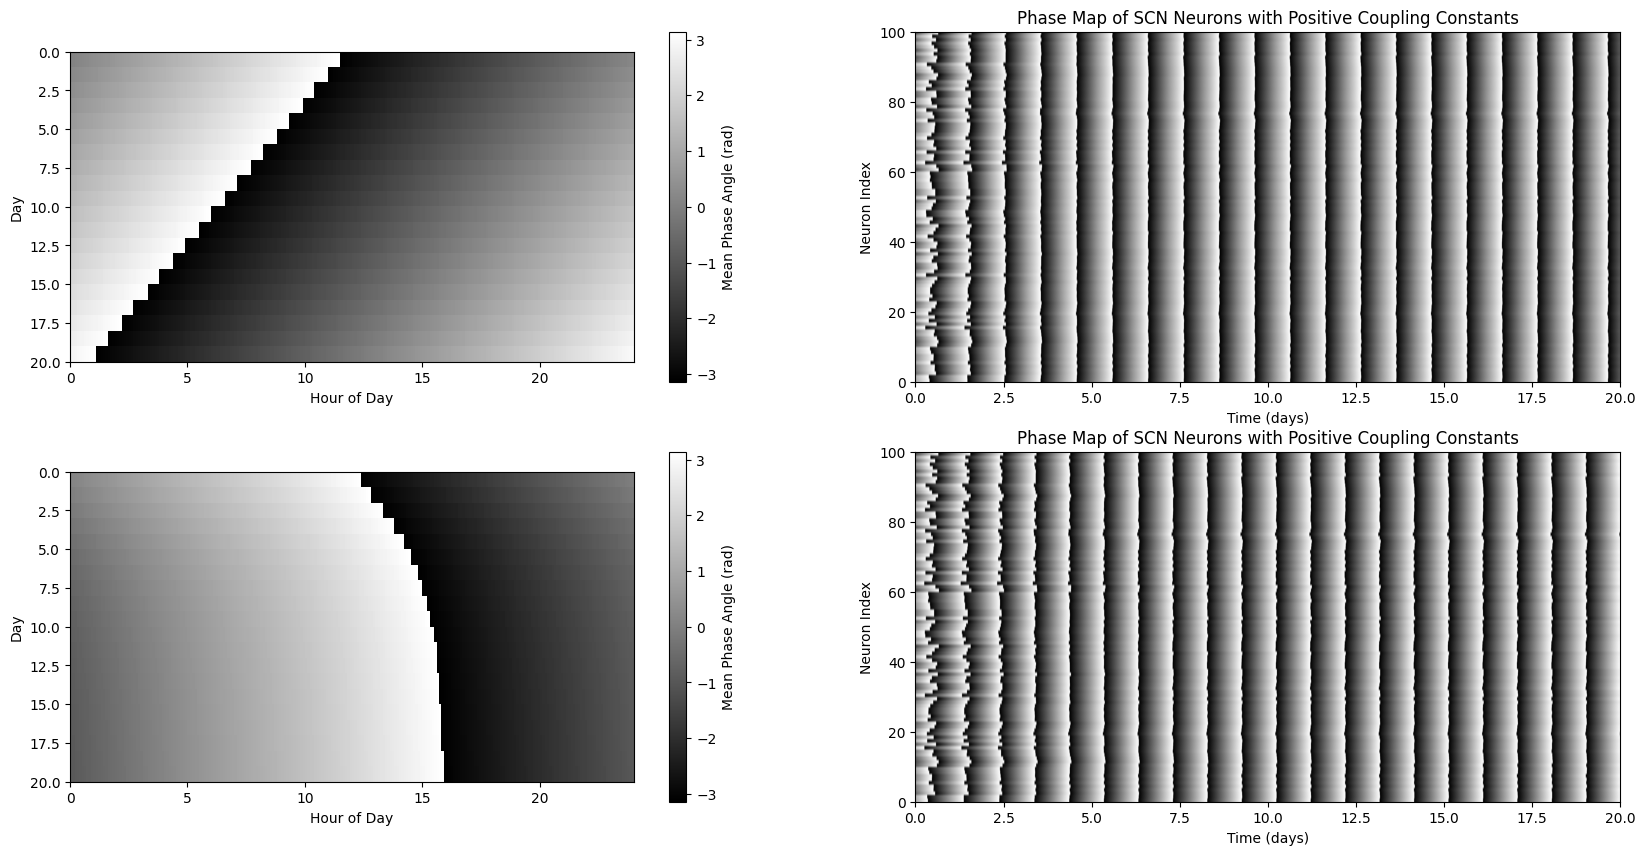

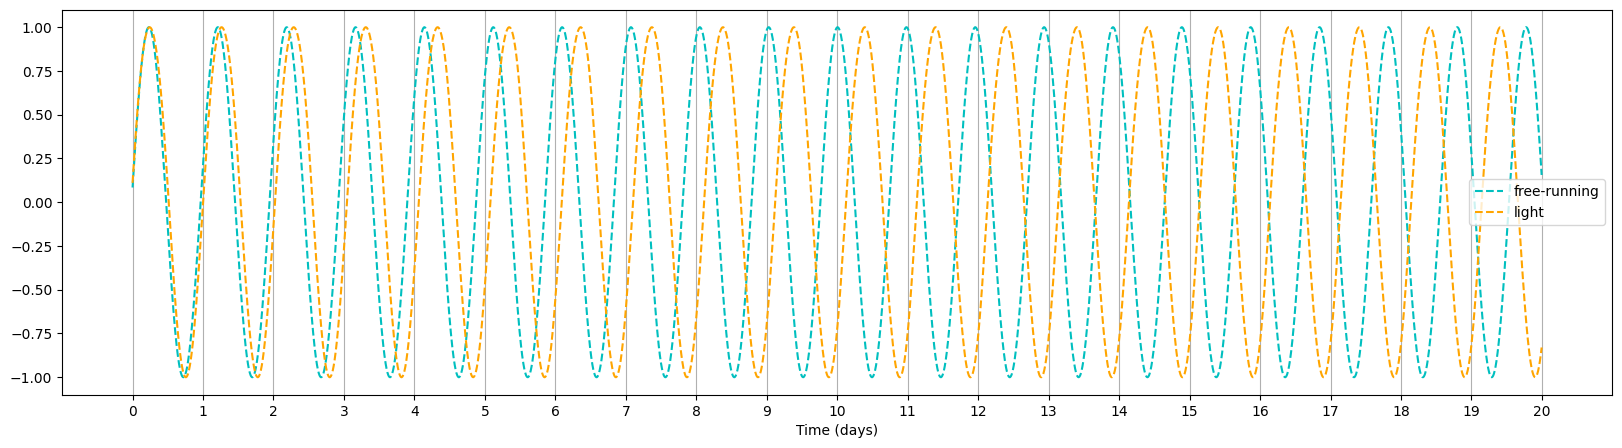

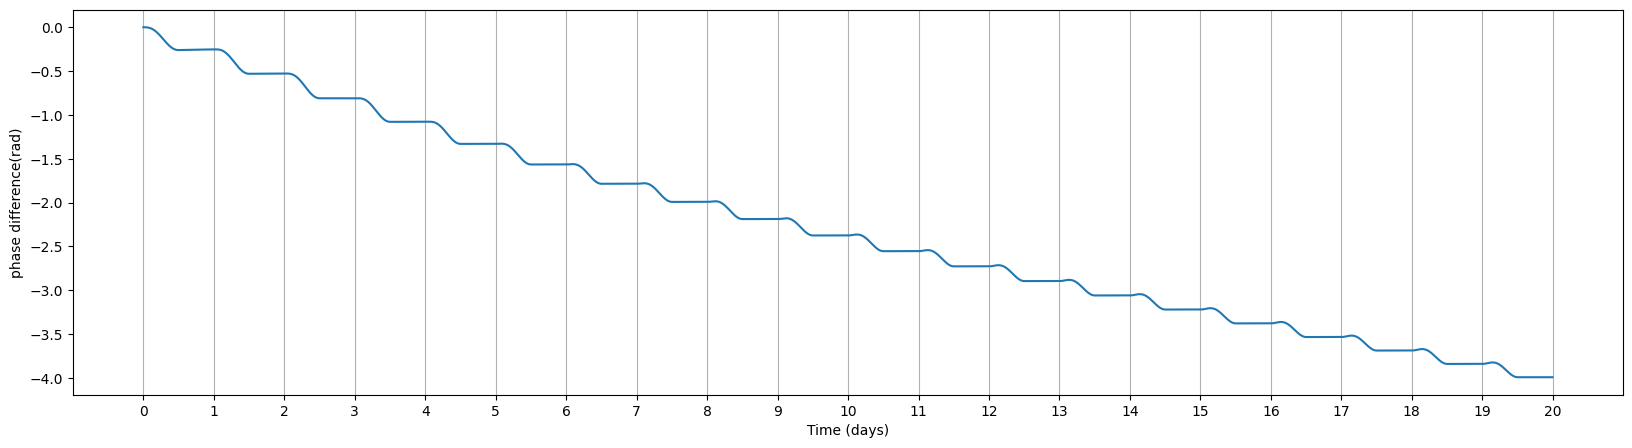

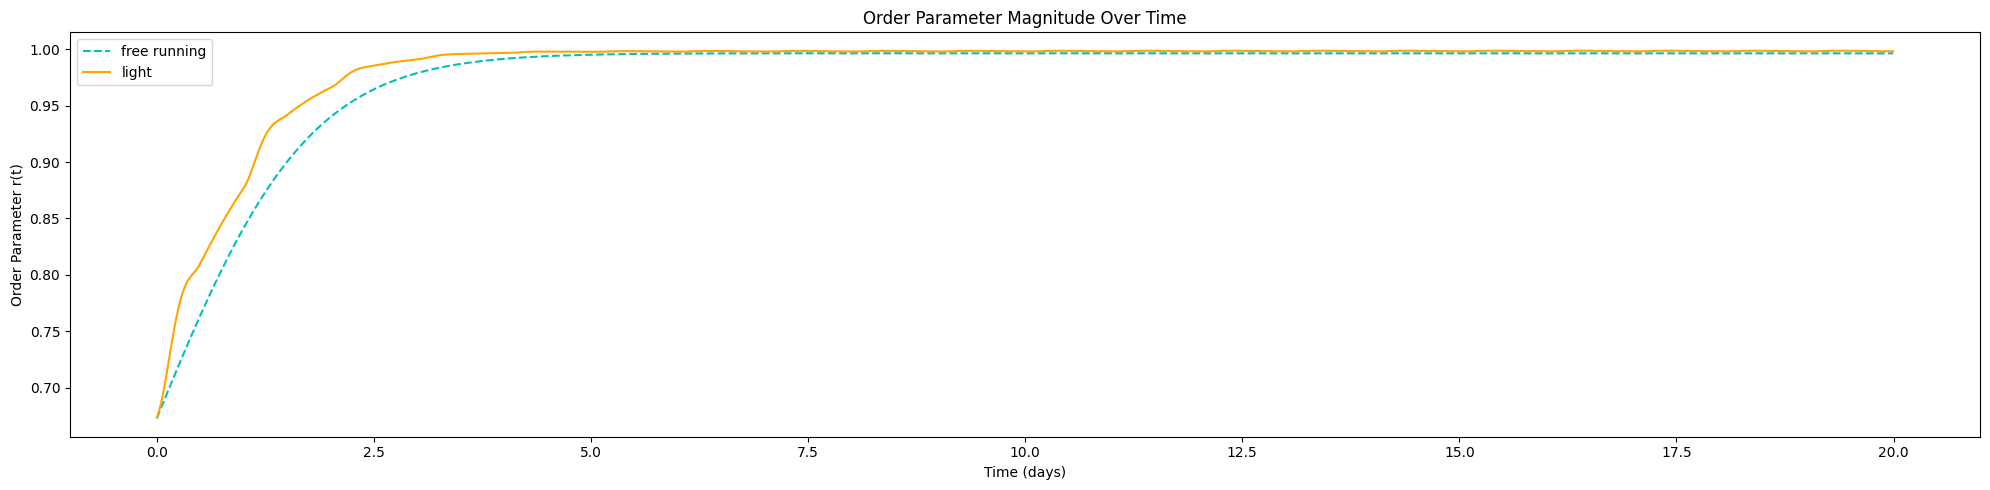

In [5]:
compare(his_phase_l, psi_l, r_l)

### light pulse stimulus


-sinusoidal interaction

-light_max=1

-timing: Day 6 05:54-06:00

In [ ]:
N = 100  # Number of oscillators

T = 24 * 20  # duration (hrs * day)
dt = 0.1   #(hrs)
time = np.arange(0, T, dt)

light_max=1

mean_period = 23.5  #hrs
std_period = 0.2 

#initialization
omega, init_phases, K_matrix = fetch()

ω=omega
phases_l = init_phases

# Storage for phase evolution
his_phase_l = np.zeros((N, len(time))) # shape = (index, timepoint)

#r(t) & psi(t)
r_l = np.zeros(len(time))  # r(t): order parameter
psi_l = np.zeros(len(time)) # psi(t): mean phase angle

for t in tqdm(range(len(time)), desc="Simulating", ncols=80):
    time_of_day=12

    if (t*dt)//24 == 5 and (5.9 < (t*dt) % 24 <= 6 ):
        light_input = light_max
    else:
        light_input=0
    
    his_phase_l[:, t] = phases_l
    
    # Compute the order parameter r and mean phase psi
    order_param = np.mean(np.exp(1j * phases_l)) ; '->np.mean(complex number) = np.ang + np.abs'
    r_l[t] = np.abs(order_param)
    psi_l[t] = np.angle(order_param)

    for i in range(N):
        coupling_sum = 0
        
        for j in range(N):
            coupling_sum += np.sum(K_matrix[i,j] * np.sin(phases_l[j] - phases_l[i]))
        
        phases_l[i] += (ω[i] + (1/N) * coupling_sum + light_input * np.sin((2*np.pi*(psi_l[t]/mean_period)-phases_l[i])) ) * dt

    phases_l = np.mod(phases_l+np.pi,  2 * np.pi) - np.pi

Simulating: 100%|███████████████████████████| 4800/4800 [03:53<00:00, 20.59it/s]


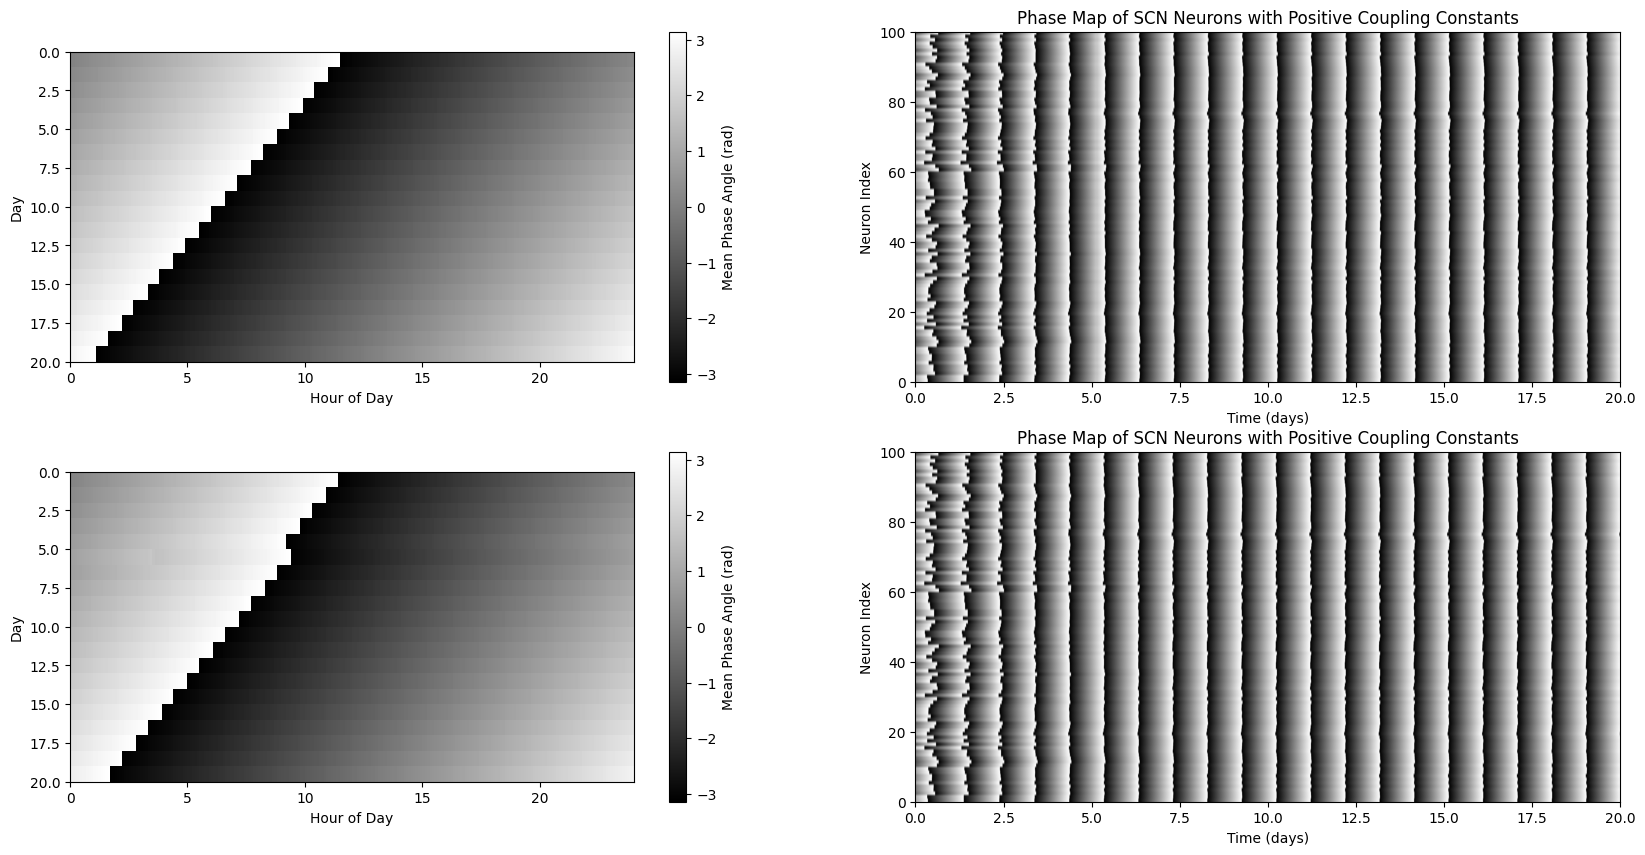

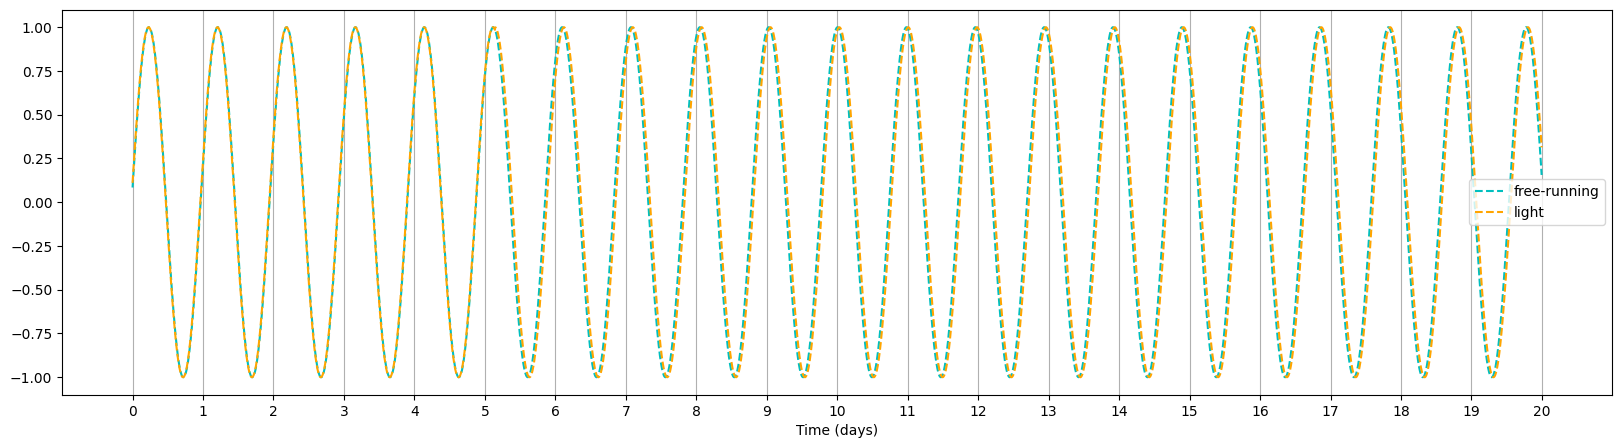

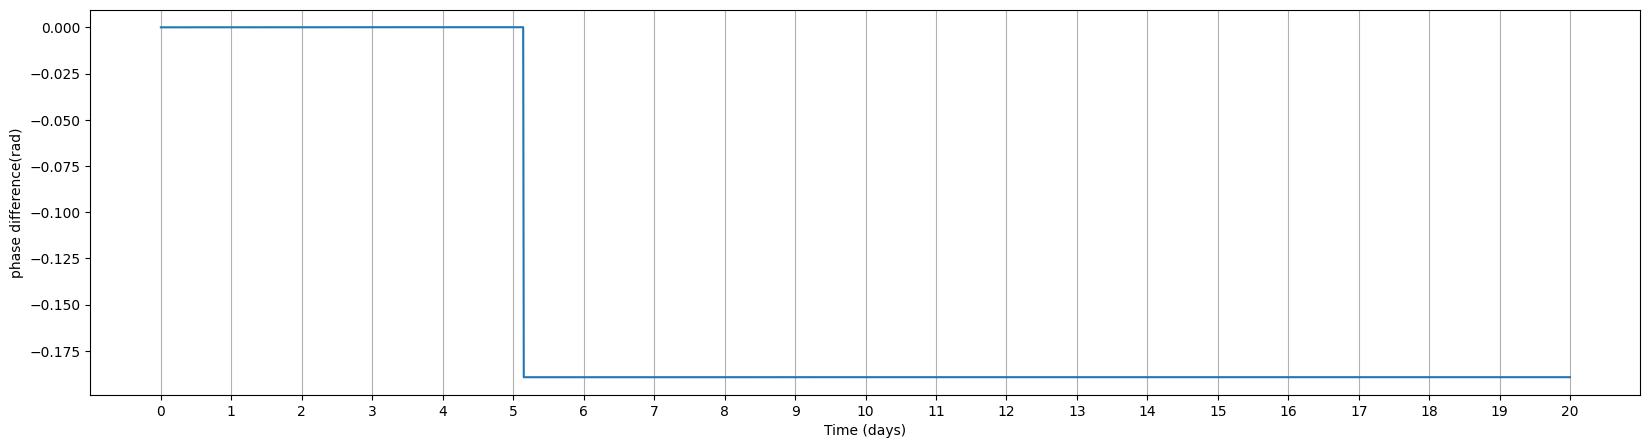

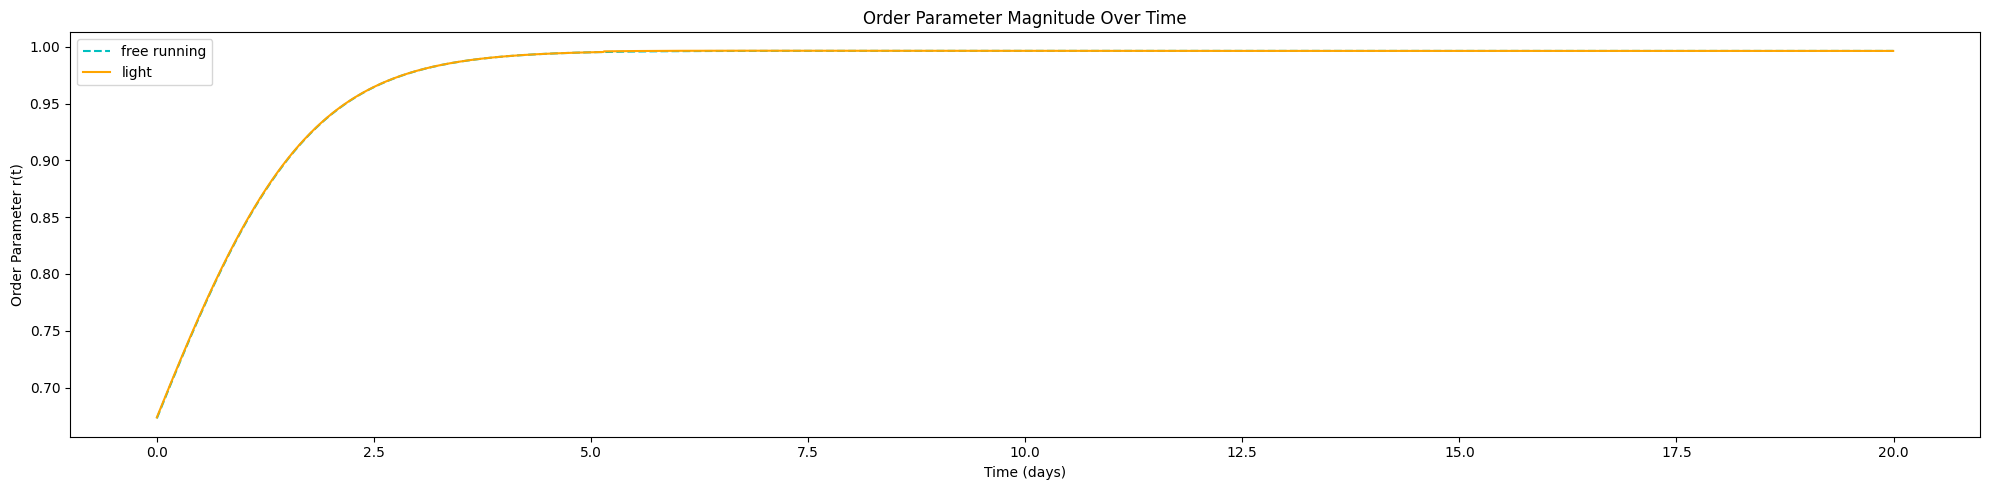

In [12]:
compare(his_phase_l, psi_l, r_l)

$\large \rightarrow~phase~delay$


-sinusoidal interaction

-light_max=1

-timing: Day 6 17:54-18:00

In [13]:
N = 100  # Number of oscillators

T = 24 * 20  # duration (hrs * day)
dt = 0.1   #(hrs)
time = np.arange(0, T, dt)

light_max=1

mean_period = 23.5  #hrs
std_period = 0.2 

#initialization
omega, init_phases, K_matrix = fetch()

ω=omega
phases_l = init_phases

# Storage for phase evolution
his_phase_l = np.zeros((N, len(time))) # shape = (index, timepoint)
diff_inspect= np.zeros((N, len(time)))
#r(t) & psi(t)
r_l = np.zeros(len(time))  # r(t): order parameter
psi_l = np.zeros(len(time)) # psi(t): mean phase angle

for t in tqdm(range(len(time)), desc="Simulating", ncols=80):
    time_of_day
    
    if (t*dt)//24 == 5 and (17.9 < (t*dt) % 24 <= 18 ):
        light_input = light_max
    else:
        light_input=0
    
    his_phase_l[:, t] = phases_l
    diff_inspect[:,t] = 2*np.pi*(time_of_day/23.5)-phases_l
    # Compute the order parameter r and mean phase psi
    order_param = np.mean(np.exp(1j * phases_l)) ; '->np.mean(complex number) = np.ang + np.abs'
    r_l[t] = np.abs(order_param)
    psi_l[t] = np.angle(order_param)

    for i in range(N):
        coupling_sum = 0
        
        for j in range(N):
            coupling_sum += np.sum(K_matrix[i,j] * np.sin(phases_l[j] - phases_l[i]))
        
        phases_l[i] += (ω[i] + (1/N) * coupling_sum + light_input * np.sin((2*np.pi*(psi_l[t]/23.5)-phases_l[i])) ) * dt
        
    phases_l = np.mod(phases_l+np.pi,  2 * np.pi) - np.pi

Simulating: 100%|███████████████████████████| 4800/4800 [03:50<00:00, 20.78it/s]


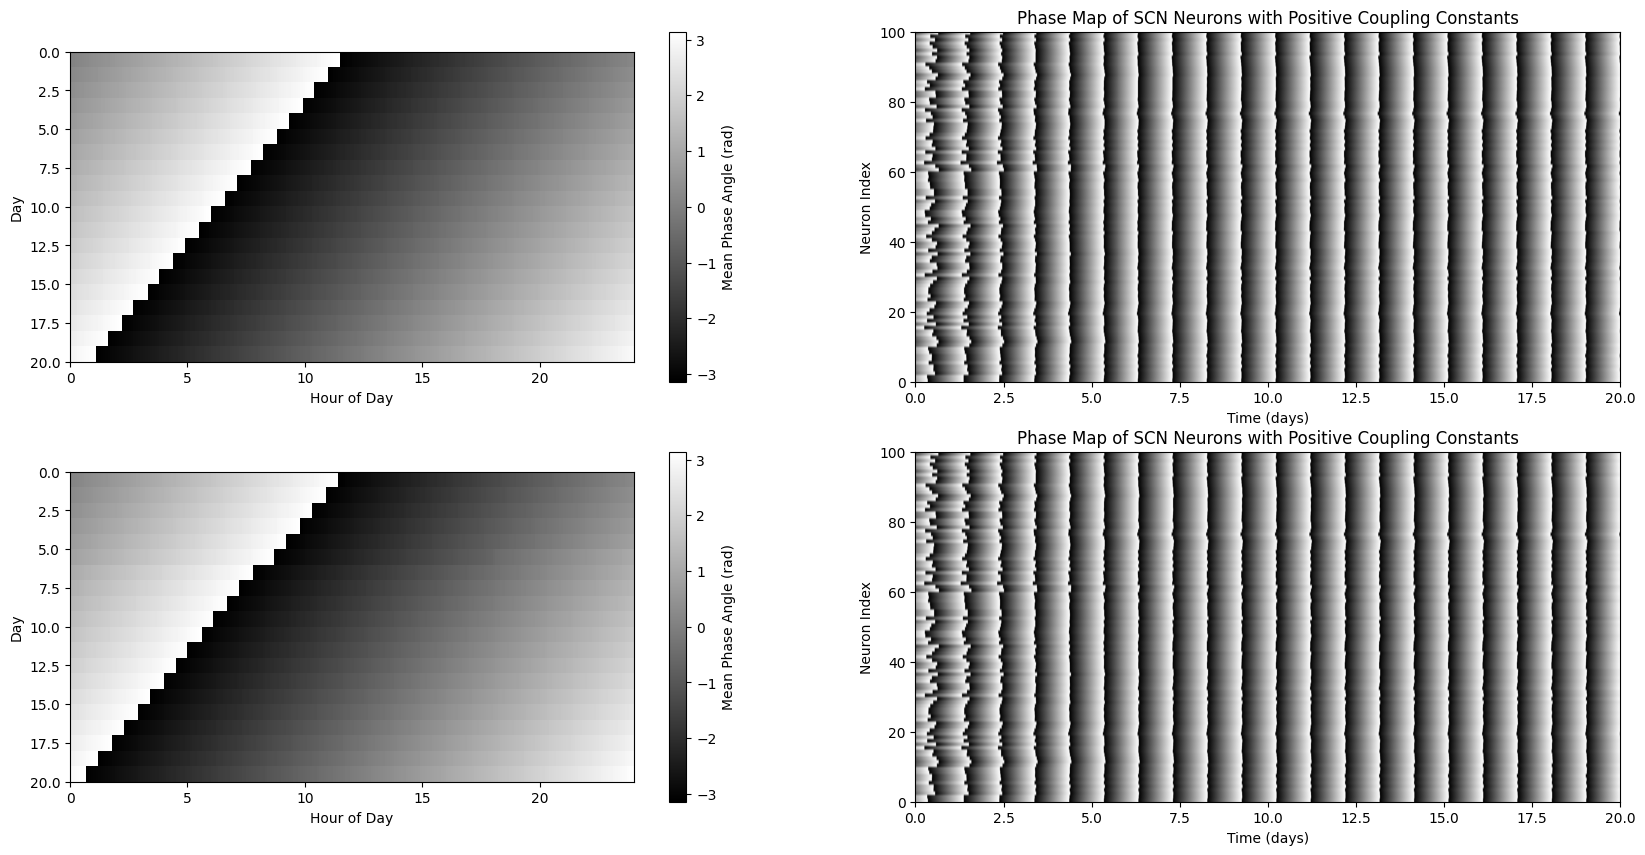

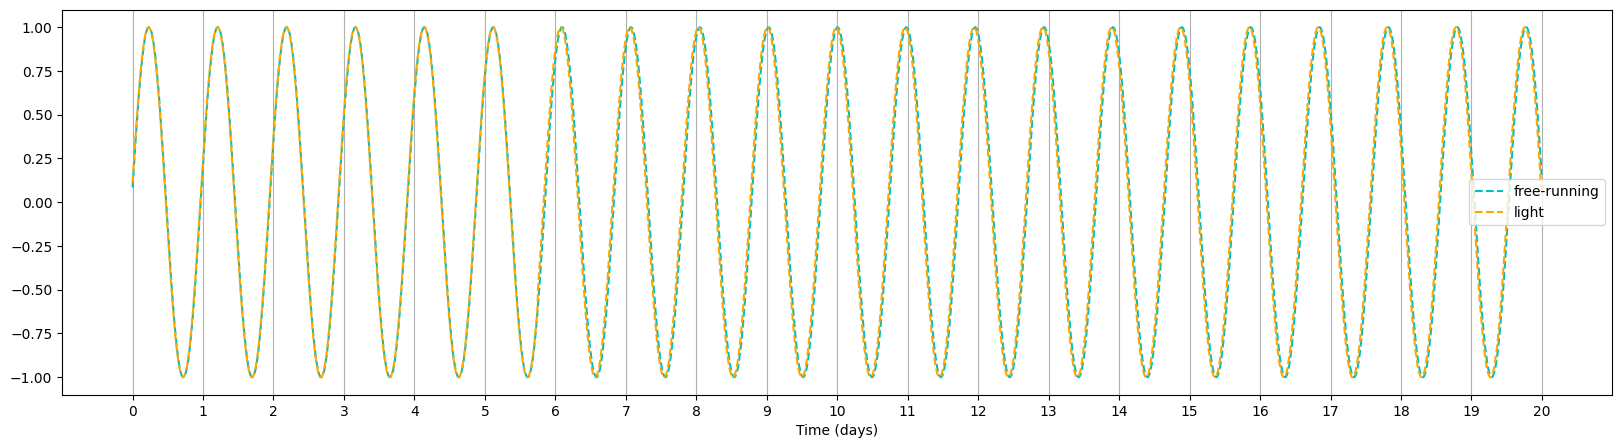

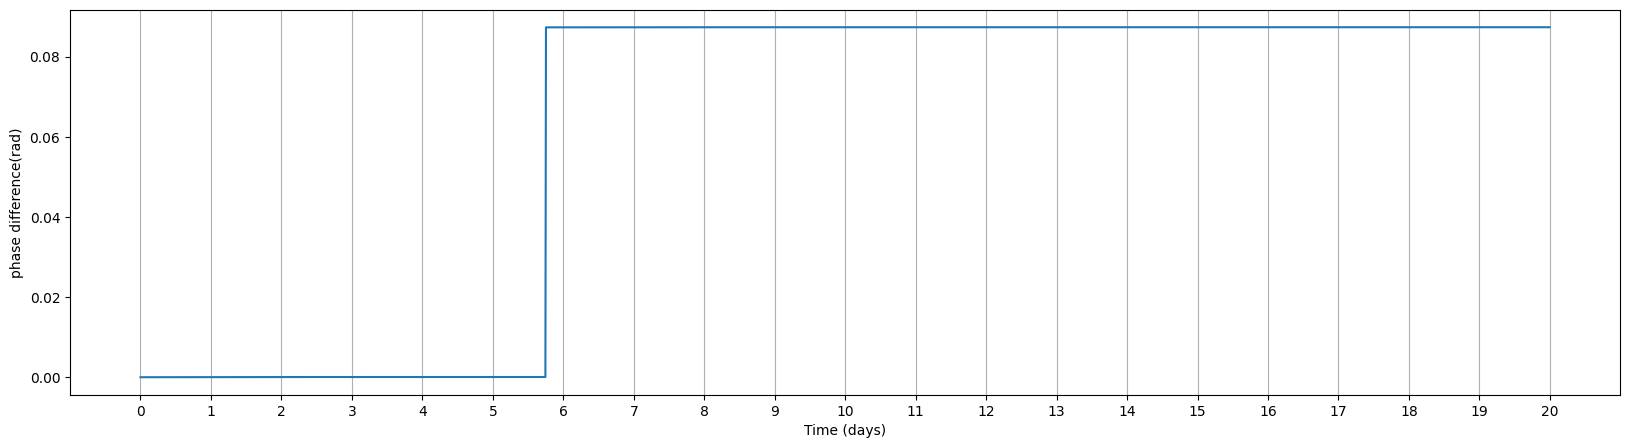

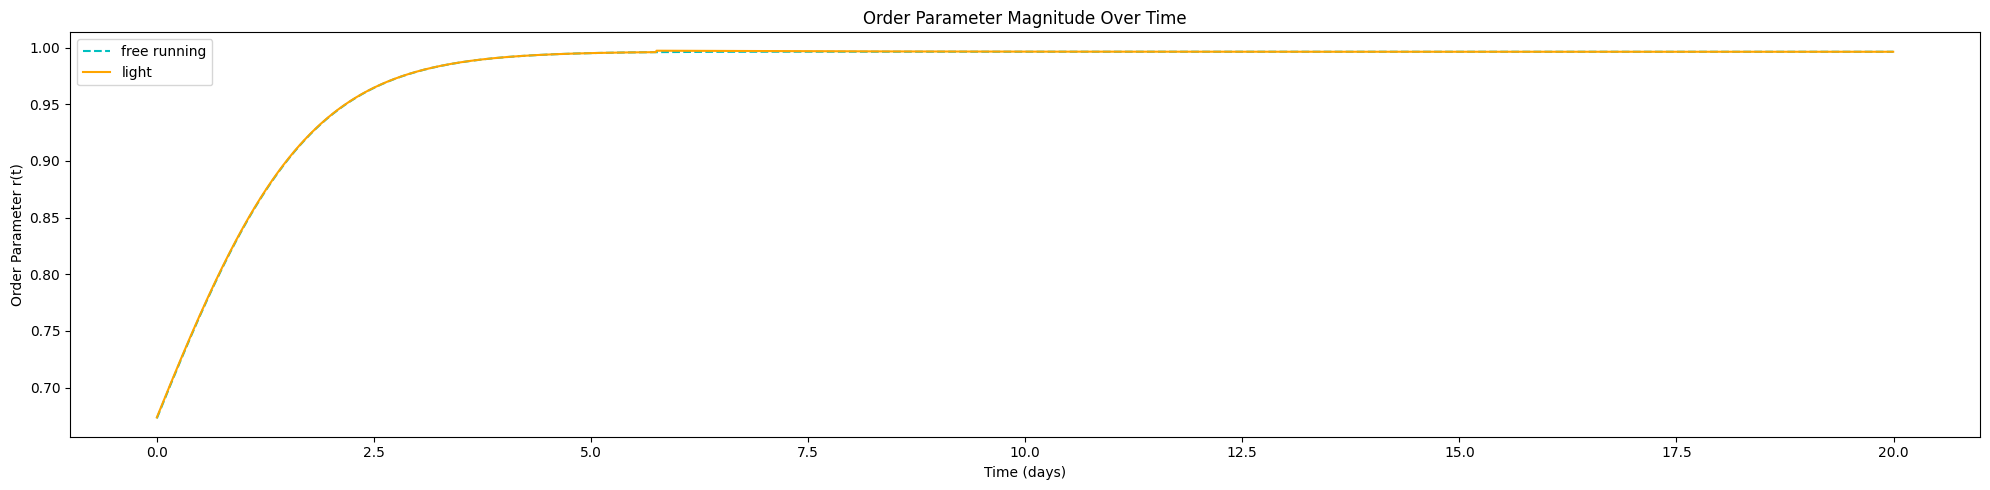

In [14]:
compare(his_phase_l, psi_l, r_l)

## Replicating Exp Result

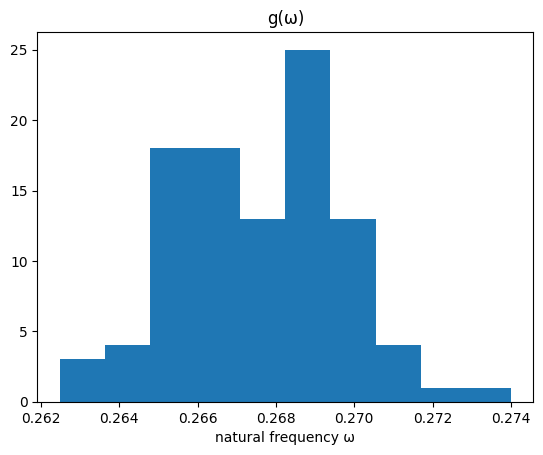

In [17]:
data=np.load('free_running_data.npz')
omega=data['omega']
hist(omega)
title('g(ω)')
xlabel('natural frequency ω');

In [18]:
data = np.load("free_running_data.npz")

psi_fr=data['psi_fr']

N = 100  # Number of oscillators

T = 23.5 * 5  # subjective time (hrs * day)
dt = 0.1   #(hrs)
time = np.arange(0, T, dt)

#light setup
light_max=1
interval=9

mean_period = 23.5  #hrs
std_period = 0.2 

# Storage for phase evolution
his_phase_l = np.zeros((24, N, len(time))) # shape = (index, timepoint)
diff_inspect= np.zeros((24, N, len(time)))

#r(t) & psi(t)
r_l = np.zeros((24, len(time)))  # r(t): order parameter
psi_l = np.zeros((24,len(time))) # psi(t): mean phase angle

for offset in range(0, 240, 10):
    omega, init_phases, K_matrix = fetch()
    ω=omega
    phases_l = init_phases
    for t in tqdm(range(len(time)), desc=f"Simulating {((offset+10)/10)*100/24:.2f}", ncols=80):
        
        if t==(235*4+offset):
            light_input = light_max
        else:
            light_input=0
        
        his_phase_l[int(offset/10), :, t] = phases_l
        diff_inspect[int(offset/10), :,t] = 2*np.pi*(0/mean_period)-phases_l
        # Compute the order parameter r and mean phase psi
        order_param = np.mean(np.exp(1j * phases_l)) ; '->np.mean(complex number) = np.ang + np.abs'
        r_l[int(offset/10) ,t] = np.abs(order_param)
        psi_l[int(offset/10) ,t] = np.angle(order_param)

        for i in range(N):
            coupling_sum = 0
            
            for j in range(N):
                coupling_sum += np.sum(K_matrix[i,j] * np.sin(phases_l[j] - phases_l[i]))
            
            phases_l[i] += (ω[i] + (1/N) * coupling_sum + light_input * np.sin((2*np.pi*(0/mean_period)-phases_l[i])) ) * dt

        phases_l = np.mod(phases_l+np.pi,  2 * np.pi) - np.pi

Simulating 100.00: 100%|████████████████████| 1175/1175 [00:56<00:00, 20.90it/s]


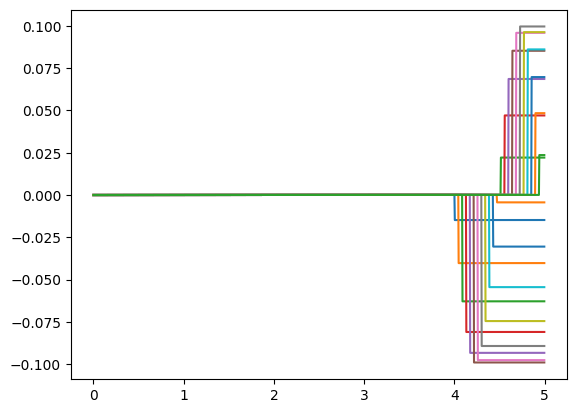

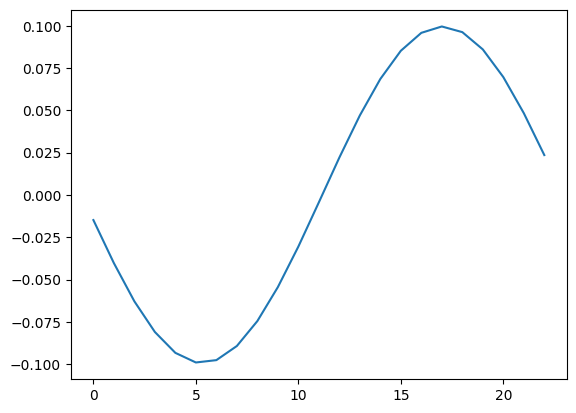

In [20]:
plot_phase_shift(psi_l)

![My Image](https://cdn.ncbi.nlm.nih.gov/pmc/blobs/c558/8775994/e53829b31946/ijms-23-00729-g002.jpg)